<a href="https://colab.research.google.com/github/Mtham049/Mtham049/blob/main/Copy_of_Final_Project_Book_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from collections import Counter
import random
import json
from google.colab import files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [ ]:
data = pd.read_csv("/content/drive/My Drive/dataFrame_wLinks.csv")
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data.head(5)

Wiki_ID                           Title                Author  \
0      620                     Animal Farm         George Orwell   
1      843              A Clockwork Orange       Anthony Burgess   
2      986                      The Plague          Albert Camus   
3     2080            A Fire Upon the Deep          Vernor Vinge   
4     2152  All Quiet on the Western Front  Erich Maria Remarque   

                                               Genre  \
0  Romanàclef,Satire,Childrensliterature,Speculat...   
1  ScienceFiction,Novella,Speculativefiction,Utop...   
2      Existentialism,Fiction,Absurdistfiction,Novel   
3  Hardsciencefiction,ScienceFiction,Speculativef...   
4                                Warnovel,Romanàclef   

                                               Links  \
0  15th Congress of the All-Union Communist Party...   
1  1985 (Anthony Burgess novel), ABBA ABBA, ARK T...   
2  A Happy Death, Absurdism, Albert Camus, Algeri...   
3  1992 in literature, A. E. van Vogt, A Canticle...   
4  A Time to Love and a Time to Die, Academy Awar...   

                                              TitAut  
0                          Animal Farm/George Orwell  
1                 A Clockwork Orange/Anthony Burgess  
2                            The Plague/Albert Camus  
3                  A Fire Upon the Deep/Vernor Vinge  
4  All Quiet on the Western Front/Erich Maria Rem...

# **Data Cleaning and Preparation**

Links and Genre - converting String to List

In [ ]:
data.update('"' + data[['Genre', 'Links']].astype(str) + '"')
data['Links']=data['Links'].astype('str')
data['Links'] = data['Links'].apply(lambda x: x[1:-1].split(','))
data['Genre']=data['Genre'].astype('str')
data['Genre'] = data['Genre'].apply(lambda x: x[1:-1].split(','))

In [ ]:
data.head()

Wiki_ID                           Title                Author  \
0      620                     Animal Farm         George Orwell   
1      843              A Clockwork Orange       Anthony Burgess   
2      986                      The Plague          Albert Camus   
3     2080            A Fire Upon the Deep          Vernor Vinge   
4     2152  All Quiet on the Western Front  Erich Maria Remarque   

                                               Genre  \
0  [Romanàclef, Satire, Childrensliterature, Spec...   
1  [ScienceFiction, Novella, Speculativefiction, ...   
2  [Existentialism, Fiction, Absurdistfiction, No...   
3  [Hardsciencefiction, ScienceFiction, Speculati...   
4                             [Warnovel, Romanàclef]   

                                               Links  \
0  [15th Congress of the All-Union Communist Part...   
1  [1985 (Anthony Burgess novel),  ABBA ABBA,  AR...   
2  [A Happy Death,  Absurdism,  Albert Camus,  Al...   
3  [1992 in literature,  A. E. van Vogt,  A Canti...   
4  [A Time to Love and a Time to Die,  Academy Aw...   

                                              TitAut  
0                          Animal Farm/George Orwell  
1                 A Clockwork Orange/Anthony Burgess  
2                            The Plague/Albert Camus  
3                  A Fire Upon the Deep/Vernor Vinge  
4  All Quiet on the Western Front/Erich Maria Rem...

In [ ]:
# index_book=pd.Series(data.TitAut.values,index=data.index).to_dict()
# book_index=pd.Series(data.index.values,index=data.TitAut).to_dict()

In [ ]:
# with open('index_book.json', 'w') as f:
#     json.dump(index_book, f)
# files.download('index_book.json')

In [ ]:
# with open('book_index.json', 'w') as f:
#     json.dump(book_index, f)
# files.download('book_index.json')

In [ ]:
links = Counter(link.lower().strip() for row in data.Links for link in row)
wlinks = [link.lower().strip() for row in data.Links for link in row]

### **Visualization before cleaning**

In [ ]:
len(wlinks)

872233

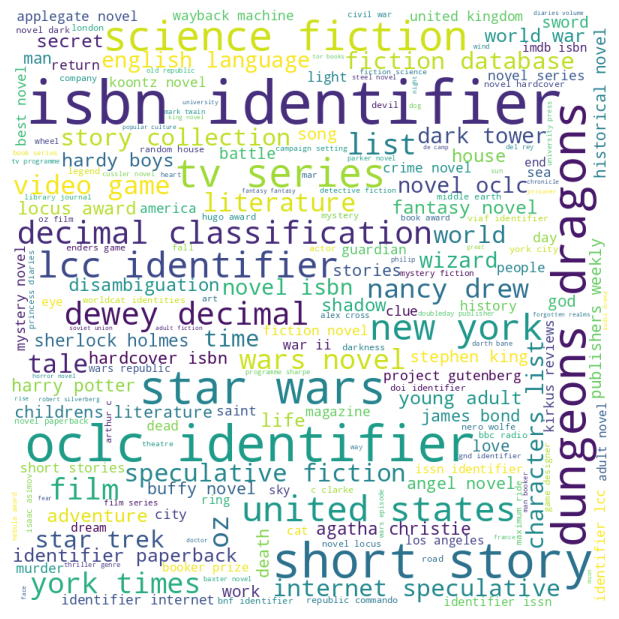

In [ ]:
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(wlinks))

# display the word cloud
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
n = 10
top_words = links.most_common(n)
top_words

[('isbn (identifier)', 9808),
 ('oclc (identifier)', 6706),
 ('paperback', 3819),
 ('hardcover', 3630),
 ('lcc (identifier)', 3397),
 ('dewey decimal classification', 2454),
 ('science fiction', 1928),
 ('novel', 1475),
 ('internet speculative fiction database', 1332),
 ('english language', 1202)]

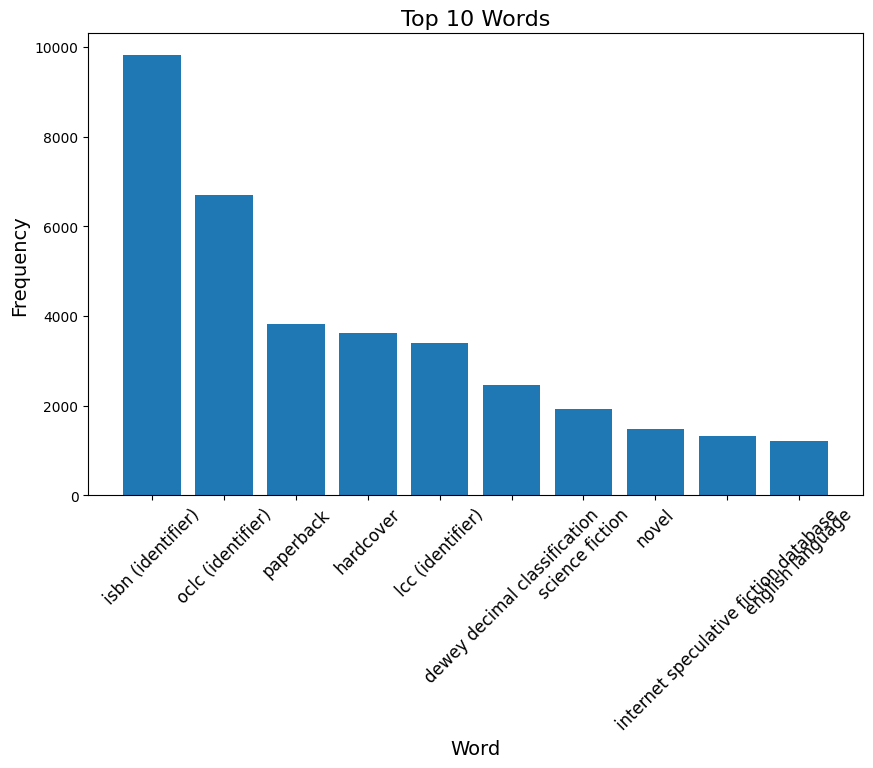

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(top_words)), [count for word, count in top_words])
ax.set_xticks(range(len(top_words)))
ax.set_xticklabels([word for word, count in top_words], fontsize=12, rotation=45) # rotate the labels on the y-axis
ax.set_xlabel('Word', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Top 10 Words', fontsize=16)
plt.show()

In [ ]:
# plot some graph and visualization

### **Removing unwanted tags**


Here we are removing the unwanted tags such as "paperback", "novel", "hardcover" and so on. At the same time, we are creating the positive dataset which is required for training the ANN.

In [ ]:
pos_data = []
links_freq = dict(links)
unique_links = []
count = 0
temp_book_links = {}
book_link_ws = {}
temp_plot={}
link_to_remove = ['paperback', 'novel', 'hardcover', 'imdb', 'nan', 'wikisource', 'hardback', 'e-book', 'inc.', 'i', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for row in data.itertuples():
    temp_book_links[row.TitAut] = []
    temp_plot[row.TitAut] = []
    book_link_ws[row.TitAut] = []
    for link in row.Links:
        link = link.lower()
        link = link.strip()
        if ('identifier' not in link) and (link not in link_to_remove) and (links_freq[link]>1) and (len(link)>2):
          pos_data.append([row.TitAut, link, 1])
          temp_book_links[row.TitAut].append(link)
          book_link_ws[row.TitAut].append(link.replace(" ",""))
          unique_links.append(link)
        if ('identifier' not in link) and (link not in link_to_remove) and (links_freq[link]>20) and (len(link)>2):
          temp_plot[row.TitAut].append(link.replace(" ",""))
        else:
          count+=1
    # if len(temp_book_links[row.TitAut]) < 20:
    #   del temp_book_links[row.TitAut]
    # print(row.Index)

In [ ]:
random.sample(pos_data, 10)

[['Kidnapped/Robert Louis Stevenson', 'factor (agent)', 1],
 ['Baalyakaalasakhi/Vaikom Muhammad Basheer', 'vanchippattu', 1],
 ['The Count of Monte Cristo/Auguste Maquet', 'this is orson welles', 1],
 ['The Pirates of Malaysia/Emilio Salgari', 'sandokan', 1],
 ['The Blood Doctor/Ruth Rendell', 'the speaker of mandarin', 1],
 ['The Facts in the Case of M. Valdemar/Edgar Allan Poe', 'hop-frog', 1],
 ['Energy Victory: Winning the War on Terror by Breaking Free of Oil/Robert Zubrin',
  'transition town',
  1],
 ['Startide Rising/David Brin', 'locus award for best young adult book', 1],
 ['Allegiance/Timothy Zahn', 'the master of disguise (novel)', 1],
 ['Odd Girl Out/Timothy Zahn', 'the beebo brinker chronicles', 1]]

In [ ]:
k = pd.DataFrame(pos_data, columns=["book", "tag", "output"])
k.head(10)

book                                tag  output
0  Animal Farm/George Orwell               24 views of mt. fuji       1
1  Animal Farm/George Orwell                         by hokusai       1
2  Animal Farm/George Orwell               a case of conscience       1
3  Animal Farm/George Orwell              a clergymans daughter       1
4  Animal Farm/George Orwell  a good word for the vicar of bray       1
5  Animal Farm/George Orwell                          a hanging       1
6  Animal Farm/George Orwell                  a nice cup of tea       1
7  Animal Farm/George Orwell                       adolf hitler       1
8  Animal Farm/George Orwell                    adrian mitchell       1
9  Animal Farm/George Orwell                   alexey stakhanov       1

**Negative Dataset Creation for ANN**

DO NOT RUN THIS CELL. It will take lot of time. Instead use dataset.csv file. This code will be commented.

In [ ]:
neg_data = []
for row in data.itertuples():
    temp = list(set(unique_links).difference(set(temp_book_links[row.TitAut])))
    random_items = random.sample(temp, len(temp_book_links[row.TitAut]))
    for items in random_items:
     neg_data.append([row.TitAut, items, 0])
dataset = neg_data+pos_data
dataset = pd.DataFrame(dataset, columns = ["BookAuthor", "Link", "Output"])
dataset = dataset.sample(frac=1, random_state=42)
dataset.head()

BookAuthor  \
543869          Where There's a Will/Rex Stout   
476739          Conan the Buccaneer/Lin Carter   
190102        Blood of Elves/Andrzej Sapkowski   
185437  The Guns of the South/Harry Turtledove   
962153          Son of a Witch/Gregory Maguire   

                                                     Link  Output  
543869                                  septimius severus       0  
476739                                    biota (ecology)       0  
190102                           molecular nanotechnology       0  
185437                                   heretics of dune       0  
962153  wicked: the life and times of the wicked witch...       1

In [ ]:
k = pd.DataFrame(neg_data, columns = ["Book", "Link", "Output"])
k.sample(5)

Book                              Link  \
178197      Boy's Life/Robert R. McCammon    harry potter trading card game   
380943       The Poe Shadow/Matthew Pearl                       scotts view   
566465  Phoenix And Ashes/Mercedes Lackey                    sicilian mafia   
38132         I, the Jury/Mickey Spillane                    tidally locked   
415744              Dead Souls/Ian Rankin  the woman who walked in sunshine   

        Output  
178197       0  
380943       0  
566465       0  
38132        0  
415744       0

In [ ]:
# dataset.to_csv("dataset.csv", index = False)

### **Visualization after cleaning**

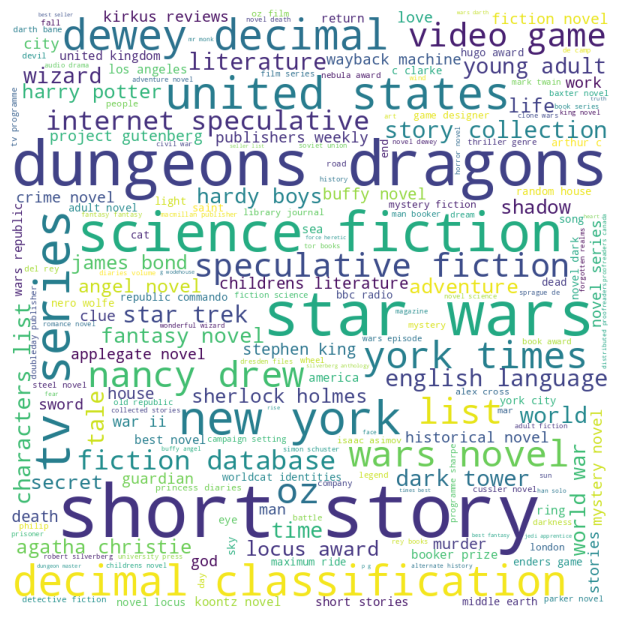

In [ ]:
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(unique_links))

# display the word cloud
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
n = 10
t = Counter(unique_links)
top_words = t.most_common(n)
top_words

[('dewey decimal classification', 2454),
 ('science fiction', 1928),
 ('internet speculative fiction database', 1332),
 ('english language', 1202),
 ('the new york times', 1050),
 ('united states', 1020),
 ('fantasy novel', 956),
 ('childrens literature', 764),
 ('fantasy', 737),
 ('historical novel', 694)]

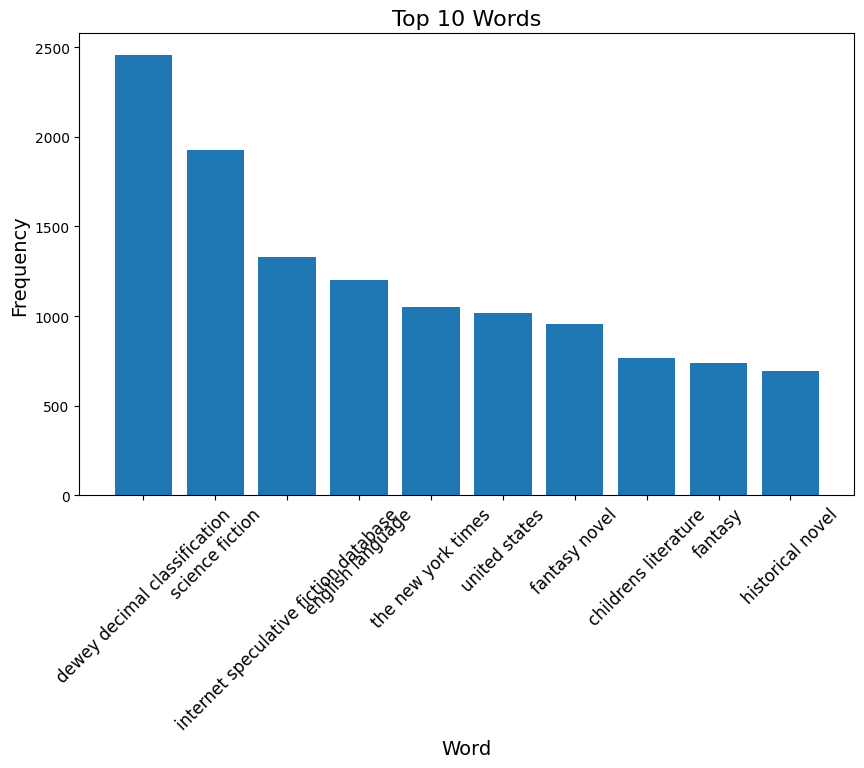

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(top_words)), [count for word, count in top_words])
ax.set_xticks(range(len(top_words)))
ax.set_xticklabels([word for word, count in top_words], fontsize=12, rotation=45) # rotate the labels on the y-axis
ax.set_xlabel('Word', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Top 10 Words', fontsize=16)
plt.show()

In [ ]:
# dewey decimal classification
book_list = []
for book in temp_book_links:
  if 'childrens literature' in temp_book_links[book]:
    book_list.append(book)
book_list

['A Wizard of Earthsea/Ursula K. Le Guin',
 'Farmer Giles of Ham/J. R. R. Tolkien',
 'Stuart Little/E. B. White',
 'The Hobbit/J. R. R. Tolkien',
 'The Invisible Man/H. G. Wells',
 "The Magician's Nephew/C. S. Lewis",
 'The Patchwork Girl of Oz/L. Frank Baum',
 'The Wonderful Wizard of Oz/L. Frank Baum',
 'Charlie and the Chocolate Factory/Roald Dahl',
 'Harriet the Spy/Louise Fitzhugh',
 'The Weirdstone of Brisingamen/Alan Garner',
 'The Adventures of Pinocchio/Carlo Collodi',
 "Uncle Tom's Cabin/Harriet Beecher Stowe",
 'Coraline/Neil Gaiman',
 'The Railway Children/E. Nesbit',
 'The Hundred and One Dalmatians/Dodie Smith',
 'Goodnight Moon/Margaret Wise Brown',
 'The Velveteen Rabbit/Margery Williams',
 'The BFG/Roald Dahl',
 'Prince Caspian/C. S. Lewis',
 'The Lion, the Witch and the Wardrobe/C. S. Lewis',
 "Charlotte's Web/E. B. White",
 'Freaky Friday/Mary Rodgers',
 'The Emerald City of Oz/L. Frank Baum',
 'Skellig/David Almond',
 'The Road to Oz/L. Frank Baum',
 'The Last Battl

In [ ]:
"Stuart Little, Farmer Giles of Ham, Prince Caspian, The Marvelous Land of Oz, The Railway Children, The Princess and the Goblin, The Magician's Nephew"

### **Dataset creation for Classification**

In [ ]:
temp = []
for i in book_link_ws:
  if len(book_link_ws[i])>200:
    temp.append(i)

random.seed(25)
books_clf = random.sample(temp, 20)

data_clf = []
books_clf_df = []
random.seed()
for book in books_clf:
  i=0
  # print(book)
  while(i<20):
    temp = random.sample(book_link_ws[book], 20)
    temp.sort()
    if temp not in data_clf:
      data_clf.append(temp)
      books_clf_df.append(book)
      i+=1
    else:
      print("duplicate")
      print(book)
      print(temp)

temp = []
vis_data = []
for link in data_clf:
  temp.append(" ".join(link))
temp[0]
data_clf=temp

dataframe_clf = pd.DataFrame({'book':books_clf_df, 'link':data_clf})
dataframe_clf = dataframe_clf.sample(frac=1, random_state=42)
dataframe_clf


book  \
209                    On Stranger Tides/Tim Powers   
280             Conan the Outcast/Leonard Carpenter   
33                            Ringworld/Larry Niven   
210                    On Stranger Tides/Tim Powers   
93                A Midsummer Tempest/Poul Anderson   
..                                              ...   
71    The Hidden Valley of Oz/Rachel Cosgrove Payes   
106  Alice's Adventures in Wonderland/Lewis Carroll   
270                    The Forever War/Joe Haldeman   
348              The Battle of Life/Charles Dickens   
102  Alice's Adventures in Wonderland/Lewis Carroll   

                                                  link  
209  actionof30march2010 albertw.hicks blockadeofaf...  
280  ageofconan andrewj.offutt conan(darkhorsecomic...  
33   amongothers aworldoutoftime escapefromhell(nov...  
210  albanianpiracy battleofty-hobay daihongdaninci...  
93   amidsummernightsdream(1935film) amidsummersnig...  
..                                                 ...  
71   dirkgringhuis dorothymeetsozmaofoz glasscat la...  
106  aliceinwonderland(1903film) alicethroughtheloo...  
270  acanticleforleibowitz atimeofchanges farmerint...  
348  alltheyearround avisitfromst.nicholas christma...  
102  aliceinmurderland(manga) alicenopaintadventure...  

[400 rows x 2 columns]

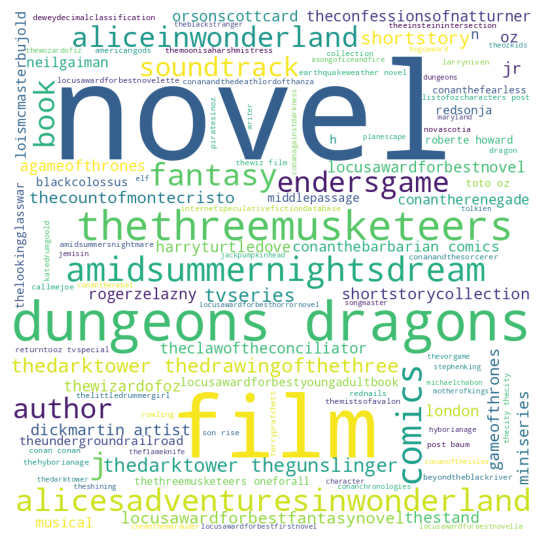

In [ ]:
st = ""
for i in dataframe_clf['link']:
  st = st+ i + " "
st = st.strip()

wordcloud = WordCloud(width=800, height=800,
                  background_color='white',
                  stopwords=None,
                  min_font_size=10).generate(st)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=10)
# plt.title(record[0]+' by '+record[1])

plt.show()
print()

# **Classification**

**Label Encoding**

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataframe_clf['book'])
print(y)

[ 6  4  8  6  1  1  9  1 14 18  5  0 10 15 18 10 14  0 19  3 15  5  3 14
  5  3  2 19 14  2  3 12 14 10 19  2  2 11 13 13  3 10 15  8  1  3 13 12
  8 17 10  9  9 15  0  8 19 17  8 13 18  4  7 15  2  8 11 14  3 15  9 13
  5 10  3  7 19  0 17  4  5  5  6  7 14 15  7 16  2  1 19  9  2 19 12 16
  0  3 19 15  7  2  5 15 13  5  5 18 11 11 18  3  4  3  4 15 15  4 16  4
 13  2  5 11  8 17 11  9 17  7 16 13  7 17  2 12 19 14  6 16  8 18  4 13
 12  4 10  2 17  0  5  9 14 13  5 12  2  1 16  3  0  6  4 17 11  1  0 17
 13 19  1 15 18  1 13  9  1 19 15  8  8 13 18 12 15 12  9  6 16 12 18 13
  0  1  9 11  9 11  9 16 12  6  4  6  4 18  8  5  9 12 19  2 17  9  4  2
  0 14  3  4  0 17  7 18 13 12 12  3  5  6  2 19 19  8 18 11 19  0  0 11
  0 18 15  9  8  1  3  2  7  4 18  7 12  4 10  0 15  1  7 12 13  5  8  8
 17 13 16 14 19  1 10  7  4 16 17 10 16  6  7  9  5  7 11  2 19 11  6 17
  1  6 15 10  8 14  6 11  8 16 19 14  4 17  0 18 15 18 18  5 15 16  5 13
 10  0  9  6 14 11 19  6  6  4  0  7  3  0 16 14  6

**Splitting dataset into train and test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataframe_clf['link'], y, test_size=0.2, random_state=42)

### **Finding the best hyper-parameters using GridSearch**

In [ ]:
# 1 =========> SVM

# Define the parameter grid to search
param_grid = [{
        'clf__C': [0.1, 1, 10, 100, 1000],
        'clf__gamma': [0.1, 1, 10, 100],
        'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    }]
# Define the pipeline with BoW and SVC
pipeline_SVM_bow = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', SVC())
])
# Define the pipeline with TfidfVectorizer and SVC
pipeline_SVM_tfid = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

# Use GridSearchCV to search over the parameter grid
grid_search_bow = GridSearchCV(pipeline_SVM_bow, param_grid, cv=5)
grid_search_tfid = GridSearchCV(pipeline_SVM_tfid, param_grid, cv=5)
# Fit the grid search to the data
grid_search_bow.fit(X_train, y_train)
grid_search_tfid.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params_bow = grid_search_bow.best_params_
best_params_tfid = grid_search_tfid.best_params_
print("SVM - best params for bow: ",best_params_bow)
print()
print("SVM - best params for tfid: ", best_params_tfid)
print()


# 2 =========> Decision Tree
# Define the parameter grid to search
param_grid = {'clf__max_depth': [5, 10, 20, None],
              'clf__min_samples_split': [2, 5, 10],
              'clf__min_samples_leaf': [1, 2, 5]}

pipeline_dt_bow = Pipeline([
    ('sc', CountVectorizer()),
    ('clf', DecisionTreeClassifier())
])
pipeline_dt_tfid = Pipeline([
    ('sc', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
])

# Use GridSearchCV to search over the parameter grid
grid_search_bow = GridSearchCV(pipeline_dt_bow, param_grid, cv=5)
grid_search_tfid = GridSearchCV(pipeline_dt_tfid, param_grid, cv=5)
# Fit the grid search to the data
grid_search_bow.fit(X_train, y_train)
grid_search_tfid.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params_bow = grid_search_bow.best_params_
best_params_tfid = grid_search_tfid.best_params_
print("DT - best params for bow: ", best_params_bow)
print()
print("DT - best params for tfid: ", best_params_tfid)
print()

# 3 =========> KNN
param_grid = {'clf__n_neighbors': [3, 5, 7, 10, 20]}

pipeline_knn_bow = Pipeline([
    ('kn', CountVectorizer()),
    ('clf', KNeighborsClassifier())
])

pipeline_knn_tfid = Pipeline([
    ('kn', TfidfVectorizer()),
    ('clf', KNeighborsClassifier())
])

# Use GridSearchCV to search over the parameter grid
grid_search_bow = GridSearchCV(pipeline_knn_bow, param_grid, cv=5)
grid_search_tfid = GridSearchCV(pipeline_knn_tfid, param_grid, cv=5)
# Fit the grid search to the data
grid_search_bow.fit(X_train, y_train)
grid_search_tfid.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params_bow = grid_search_bow.best_params_
best_params_tfid = grid_search_tfid.best_params_
print("KNN - best params for bow: ",best_params_bow)
print()
print("KNN - best params for tfid: ", best_params_tfid)
print()

SVM - best params for bow:  {'clf__C': 0.1, 'clf__gamma': 0.1, 'clf__kernel': 'linear'}

SVM - best params for tfid:  {'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': 'rbf'}

DT - best params for bow:  {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}

DT - best params for tfid:  {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}

KNN - best params for bow:  {'clf__n_neighbors': 3}

KNN - best params for tfid:  {'clf__n_neighbors': 3}



### **SVM - BoW**

 1 ========> SVM + BOW <========
                                       Prediction  \
3               The Book of Negroes/Lawrence Hill   
6   The Hidden Valley of Oz/Rachel Cosgrove Payes   
7                       Our Nig/Harriet E. Wilson   
15             The Magical Mimics in Oz/Jack Snow   
16              The Book of Negroes/Lawrence Hill   
26               Conan the Formidable/Steve Perry   
27                      Our Nig/Harriet E. Wilson   
36            Conan the Outcast/Leonard Carpenter   
39              The Book of Negroes/Lawrence Hill   
43            Conan the Outcast/Leonard Carpenter   
46  The Hidden Valley of Oz/Rachel Cosgrove Payes   
48            Conan the Outcast/Leonard Carpenter   
58            Conan the Outcast/Leonard Carpenter   
68                      Our Nig/Harriet E. Wilson   
75            Conan the Outcast/Leonard Carpenter   
76            Conan the Outcast/Leonard Carpenter   

                                           Actual  Predicted Wron

Text(0.5, 58.2222222222222, 'Predicted')

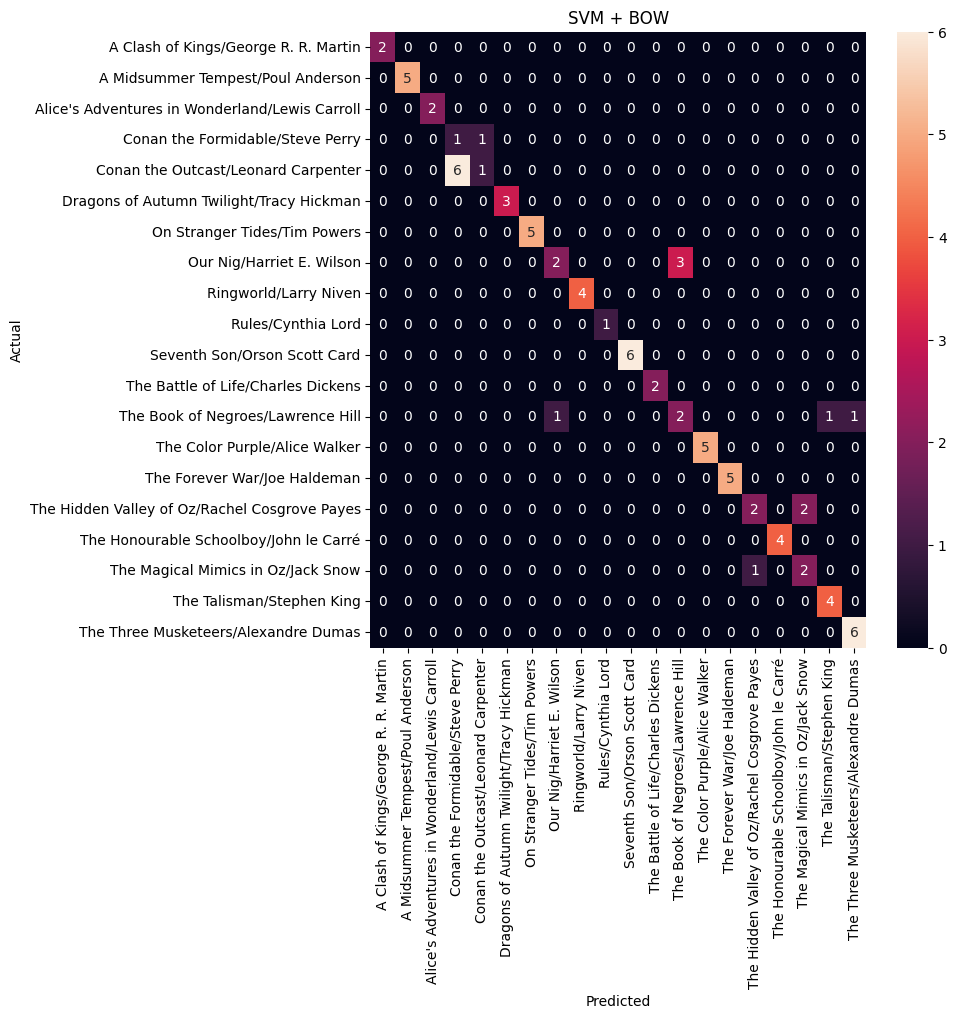

In [ ]:
# # SVM
#bow
pipeline_SVM_bow = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', SVC(C=0.1, kernel='linear', gamma=0.1))
])
pipeline_SVM_bow.fit(X_train, y_train)
test_predictions_SVM_bow = pipeline_SVM_bow.predict(X_test)
train_predictions_SVM_bow = pipeline_SVM_bow.predict(X_train)

# Extract wrong predictions
print(" 1 ========> SVM + BOW <========")
df_SVM_bow = pd.DataFrame({"Prediction": label_encoder.inverse_transform(test_predictions_SVM_bow), "Actual": label_encoder.inverse_transform(y_test)})
df_SVM_bow["Predicted Wrong"] = df_SVM_bow.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
rslt_df_SVM_bow = df_SVM_bow[df_SVM_bow["Predicted Wrong"] == False]
print(rslt_df_SVM_bow)
print()
report = classification_report(label_encoder.inverse_transform(test_predictions_SVM_bow), label_encoder.inverse_transform(y_test))
print(report)
accuracy = accuracy_score(y_test, test_predictions_SVM_bow)
print("Accuracy : ", accuracy)
conf_mat = confusion_matrix(test_predictions_SVM_bow, y_test)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('SVM + BOW')
plt.ylabel("Actual")
plt.xlabel("Predicted")


### **SVM - TFIDF**

 2 ========> SVM + TFID <========
                                       Prediction  \
0                       Our Nig/Harriet E. Wilson   
6   The Hidden Valley of Oz/Rachel Cosgrove Payes   
7                       Our Nig/Harriet E. Wilson   
15             The Magical Mimics in Oz/Jack Snow   
16              The Book of Negroes/Lawrence Hill   
26               Conan the Formidable/Steve Perry   
27                      Our Nig/Harriet E. Wilson   
36            Conan the Outcast/Leonard Carpenter   
43            Conan the Outcast/Leonard Carpenter   
46  The Hidden Valley of Oz/Rachel Cosgrove Payes   
48            Conan the Outcast/Leonard Carpenter   
58            Conan the Outcast/Leonard Carpenter   
73            Conan the Outcast/Leonard Carpenter   
75            Conan the Outcast/Leonard Carpenter   
76            Conan the Outcast/Leonard Carpenter   

                                           Actual  Predicted Wrong  
0               The Book of Negroes/Lawrence Hil

Text(0.5, 58.2222222222222, 'Predicted')

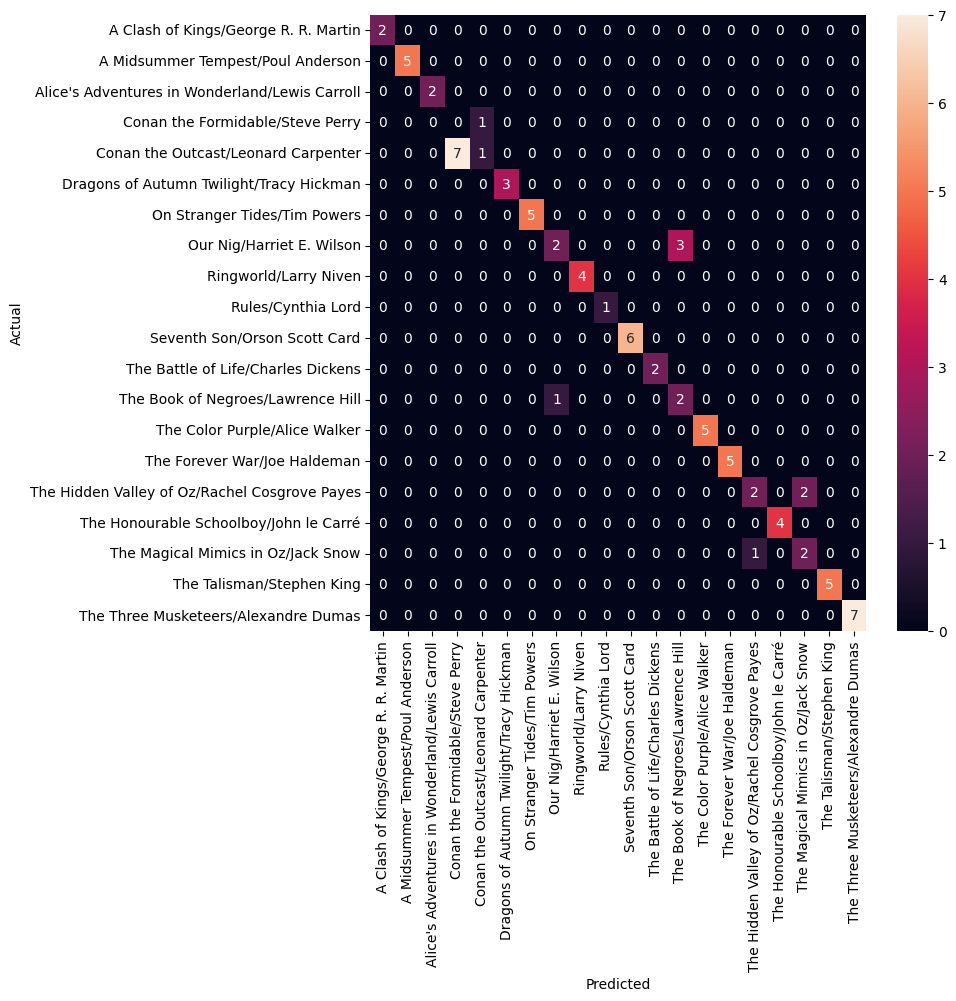

In [ ]:
# -----------------------------------------
#tfid
pipeline_SVM_tfid = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('clf', SVC(C=1, kernel='linear', gamma=1))
])
pipeline_SVM_tfid.fit(X_train, y_train)
test_predictions_SVM_tfid = pipeline_SVM_tfid.predict(X_test)
train_predictions_SVM_tfid = pipeline_SVM_tfid.predict(X_train)

# Extract wrong predictions
print(" 2 ========> SVM + TFID <========")
df_SVM_tfid = pd.DataFrame({"Prediction": label_encoder.inverse_transform(test_predictions_SVM_tfid), "Actual": label_encoder.inverse_transform(y_test)})
df_SVM_tfid["Predicted Wrong"] = df_SVM_tfid.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
rslt_df_SVM_tfid = df_SVM_tfid[df_SVM_tfid["Predicted Wrong"] == False]
print(rslt_df_SVM_tfid)
print()
report = classification_report(label_encoder.inverse_transform(test_predictions_SVM_tfid), label_encoder.inverse_transform(y_test))
print(report)
accuracy = accuracy_score(y_test, test_predictions_SVM_tfid)
print("Accuracy : ", accuracy)
conf_mat = confusion_matrix(test_predictions_SVM_tfid, y_test)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")

### **SVM - NGram**

 2 ========> SVM + TFID + NGRAM <========
                                       Prediction  \
0                       Our Nig/Harriet E. Wilson   
6   The Hidden Valley of Oz/Rachel Cosgrove Payes   
7                       Our Nig/Harriet E. Wilson   
15             The Magical Mimics in Oz/Jack Snow   
16              The Book of Negroes/Lawrence Hill   
26               Conan the Formidable/Steve Perry   
27                      Our Nig/Harriet E. Wilson   
36            Conan the Outcast/Leonard Carpenter   
43            Conan the Outcast/Leonard Carpenter   
46  The Hidden Valley of Oz/Rachel Cosgrove Payes   
48            Conan the Outcast/Leonard Carpenter   
58            Conan the Outcast/Leonard Carpenter   
73            Conan the Outcast/Leonard Carpenter   
75            Conan the Outcast/Leonard Carpenter   
76            Conan the Outcast/Leonard Carpenter   

                                           Actual  Predicted Wrong  
0               The Book of Negroes/Lawr

Text(0.5, 58.2222222222222, 'Predicted')

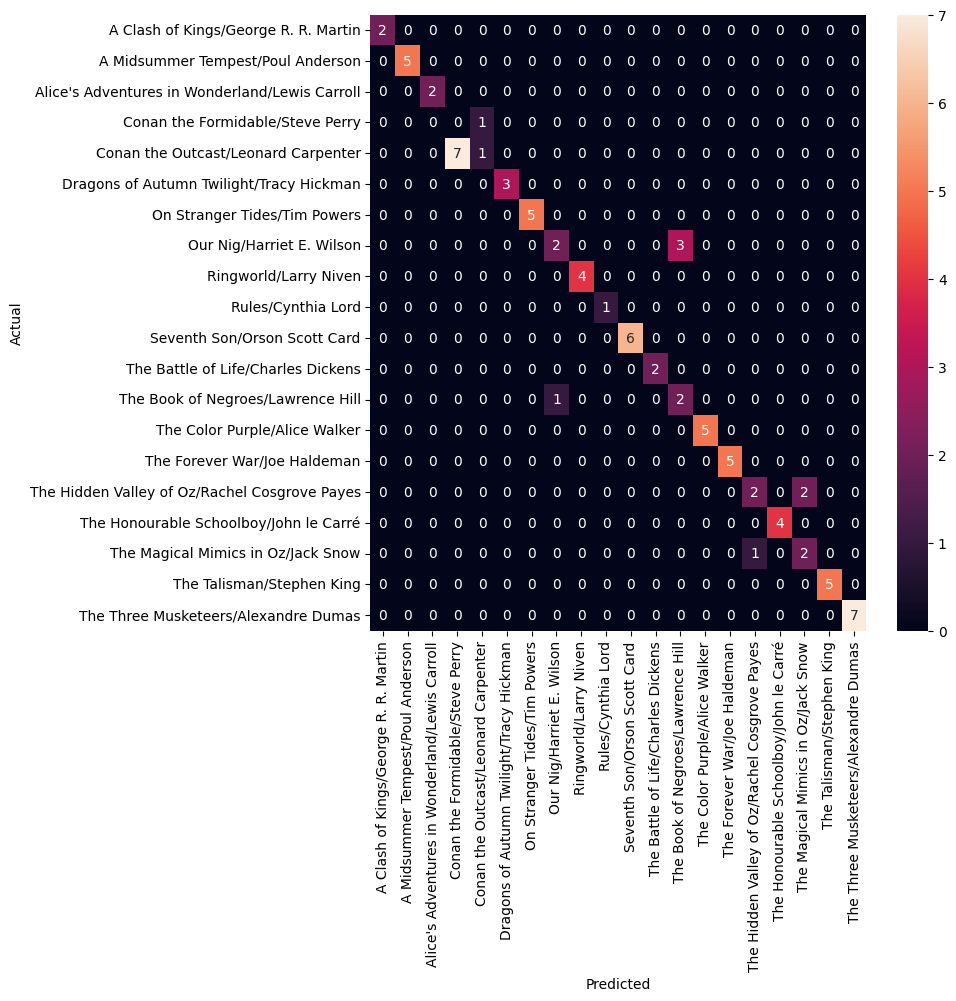

In [ ]:
#tfid-ngram
pipeline_SVM_tfid_ngram = Pipeline([
    ('tfid', TfidfVectorizer(ngram_range= (1, 2))),
    ('clf', SVC(C=1, kernel='linear', gamma=1))
])
pipeline_SVM_tfid_ngram.fit(X_train, y_train)
test_predictions_SVM_tfid_ngram = pipeline_SVM_tfid_ngram.predict(X_test)
train_predictions_SVM_tfid_ngram = pipeline_SVM_tfid_ngram.predict(X_train)

# Extract wrong predictions
print(" 2 ========> SVM + TFID + NGRAM <========")
df_SVM_tfid_ngram = pd.DataFrame({"Prediction": label_encoder.inverse_transform(test_predictions_SVM_tfid_ngram),
                                  "Actual": label_encoder.inverse_transform(y_test)})
df_SVM_tfid_ngram["Predicted Wrong"] = df_SVM_tfid_ngram.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
rslt_df_SVM_tfid_ngram = df_SVM_tfid_ngram[df_SVM_tfid_ngram["Predicted Wrong"] == False]
print(rslt_df_SVM_tfid_ngram)
print()
report = classification_report(label_encoder.inverse_transform(test_predictions_SVM_tfid_ngram),
                               label_encoder.inverse_transform(y_test))
print(report)

accuracy = accuracy_score(y_test, test_predictions_SVM_tfid)
print("Accuracy : ", accuracy)
conf_mat = confusion_matrix(test_predictions_SVM_tfid_ngram, y_test)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")

### **Decision Tree - BoW**

 1 ========> Decision Tree + BOW <========

                                                precision    recall  f1-score   support

          A Clash of Kings/George R. R. Martin       1.00      1.00      1.00         2
             A Midsummer Tempest/Poul Anderson       0.60      1.00      0.75         3
Alice's Adventures in Wonderland/Lewis Carroll       1.00      1.00      1.00         2
              Conan the Formidable/Steve Perry       0.43      1.00      0.60         3
           Conan the Outcast/Leonard Carpenter       0.50      0.20      0.29         5
      Dragons of Autumn Twilight/Tracy Hickman       1.00      1.00      1.00         3
                  On Stranger Tides/Tim Powers       0.00      0.00      0.00         0
                     Our Nig/Harriet E. Wilson       0.00      0.00      0.00         1
                         Ringworld/Larry Niven       0.50      0.11      0.17        19
                            Rules/Cynthia Lord       0.00      0.00      0.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 58.2222222222222, 'Predicted')

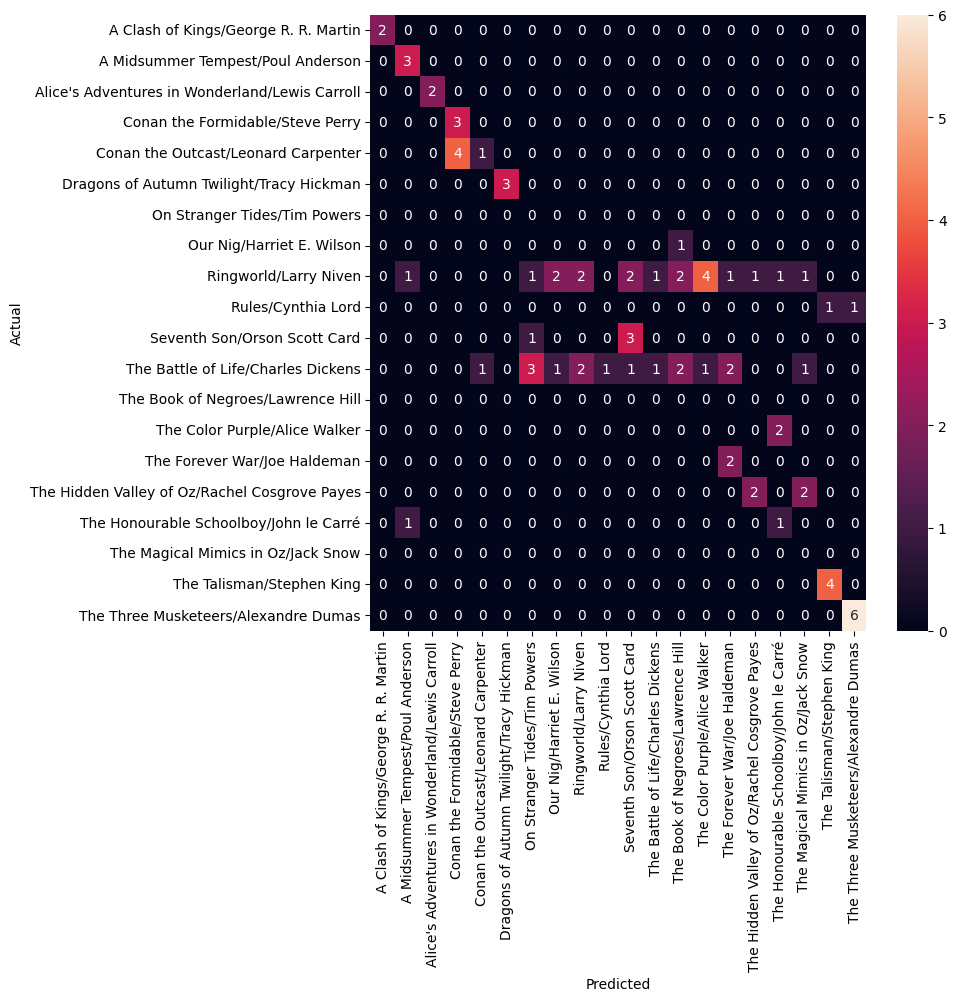

In [ ]:
# # Decision Tree
pipeline_dt_bow = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10))
])
pipeline_dt_bow.fit(X_train, y_train)
test_predictions_dt_bow = pipeline_dt_bow.predict(X_test)
train_predictions_dt_bow = pipeline_dt_bow.predict(X_train)

# Extract wrong predictions
print(" 1 ========> Decision Tree + BOW <========")
# df_dt_bow = pd.DataFrame({"Prediction": label_encoder.inverse_transform(test_predictions_dt_bow), "Actual": label_encoder.inverse_transform(y_test)})
# df_dt_bow["Predicted Wrong"] = df_dt_bow.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
# rslt_df_dt_bow = df_dt_bow[df_dt_bow["Predicted Wrong"] == False]
# print(rslt_df_dt_bow)
print()
report = classification_report(label_encoder.inverse_transform(test_predictions_dt_bow), label_encoder.inverse_transform(y_test))
print(report)

accuracy = accuracy_score(y_test, test_predictions_dt_bow)
print("Accuracy : ", accuracy)
conf_mat = confusion_matrix(test_predictions_dt_bow, y_test)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")

### **Decision Tree - TFIDF**

========> Decision + TFID <========

                                                precision    recall  f1-score   support

          A Clash of Kings/George R. R. Martin       1.00      0.50      0.67         4
             A Midsummer Tempest/Poul Anderson       0.60      1.00      0.75         3
Alice's Adventures in Wonderland/Lewis Carroll       1.00      1.00      1.00         2
              Conan the Formidable/Steve Perry       0.29      1.00      0.44         2
           Conan the Outcast/Leonard Carpenter       0.50      0.17      0.25         6
      Dragons of Autumn Twilight/Tracy Hickman       1.00      1.00      1.00         3
                  On Stranger Tides/Tim Powers       0.00      0.00      0.00         0
                     Our Nig/Harriet E. Wilson       0.33      0.50      0.40         2
                         Ringworld/Larry Niven       0.50      0.11      0.18        18
                            Rules/Cynthia Lord       1.00      0.33      0.50     

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 58.2222222222222, 'Predicted')

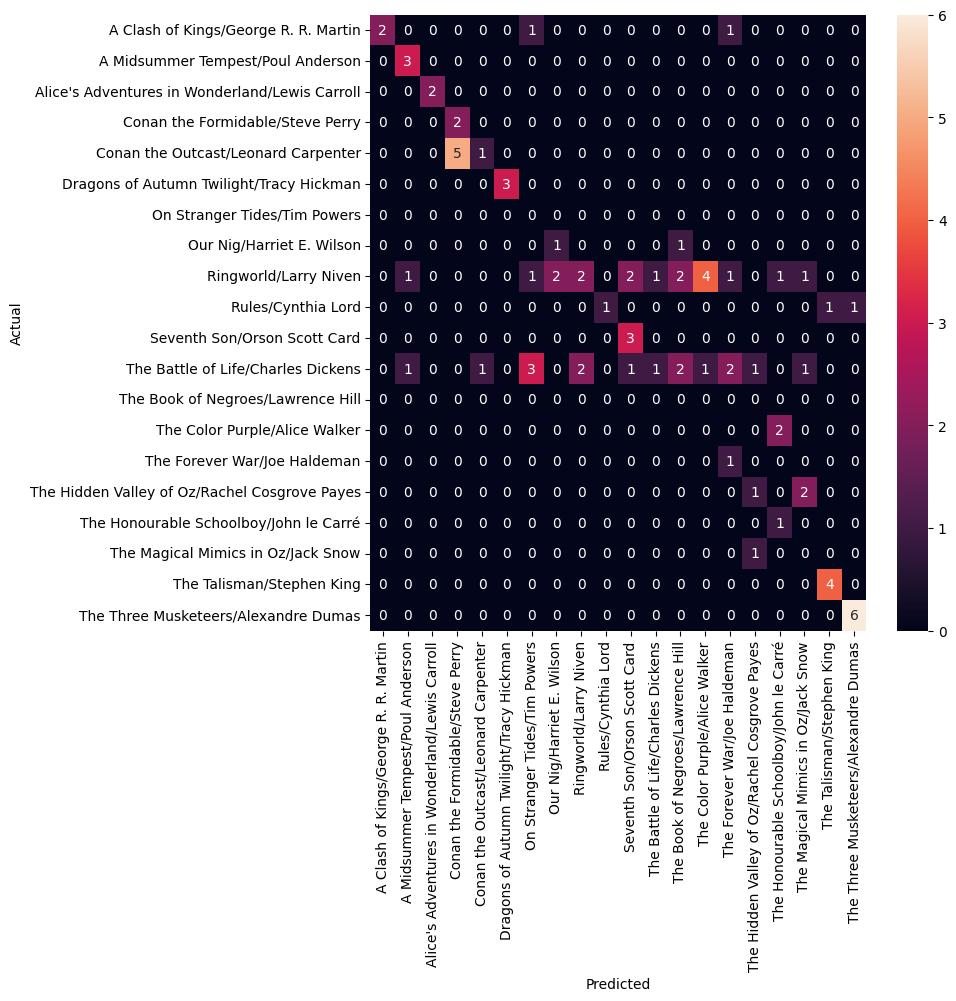

In [ ]:
pipeline_dt_tfid = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 2))
])
pipeline_dt_tfid.fit(X_train, y_train)
test_predictions_dt_tfid = pipeline_dt_tfid.predict(X_test)
train_predictions_dt_tfid = pipeline_dt_tfid.predict(X_train)

# Extract wrong predictions
print("========> Decision + TFID <========")
# df_dt_tfid = pd.DataFrame({"Prediction": label_encoder.inverse_transform(test_predictions_dt_tfid), "Actual": label_encoder.inverse_transform(y_test)})
# df_dt_tfid["Predicted Wrong"] = df_dt_tfid.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
# rslt_df_dt_tfid = df_dt_tfid[df_dt_tfid["Predicted Wrong"] == False]
# print(rslt_df_dt_tfid)
print()
report = classification_report(label_encoder.inverse_transform(test_predictions_dt_tfid), label_encoder.inverse_transform(y_test))
print(report)
accuracy = accuracy_score(y_test, test_predictions_dt_tfid)
print("Accuracy : ", accuracy)
conf_mat = confusion_matrix(test_predictions_dt_tfid, y_test)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")


### **Decision Tree - NGram**

 2 ========> Decision Tree + TFID + NGRAM <========

                                                precision    recall  f1-score   support

          A Clash of Kings/George R. R. Martin       1.00      1.00      1.00         2
             A Midsummer Tempest/Poul Anderson       0.60      1.00      0.75         3
Alice's Adventures in Wonderland/Lewis Carroll       1.00      1.00      1.00         2
              Conan the Formidable/Steve Perry       0.14      0.50      0.22         2
           Conan the Outcast/Leonard Carpenter       0.50      0.14      0.22         7
      Dragons of Autumn Twilight/Tracy Hickman       1.00      1.00      1.00         3
                  On Stranger Tides/Tim Powers       0.20      1.00      0.33         1
                     Our Nig/Harriet E. Wilson       0.67      0.50      0.57         4
                         Ringworld/Larry Niven       0.50      0.15      0.24        13
                            Rules/Cynthia Lord       0.00      0.0

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 58.2222222222222, 'Predicted')

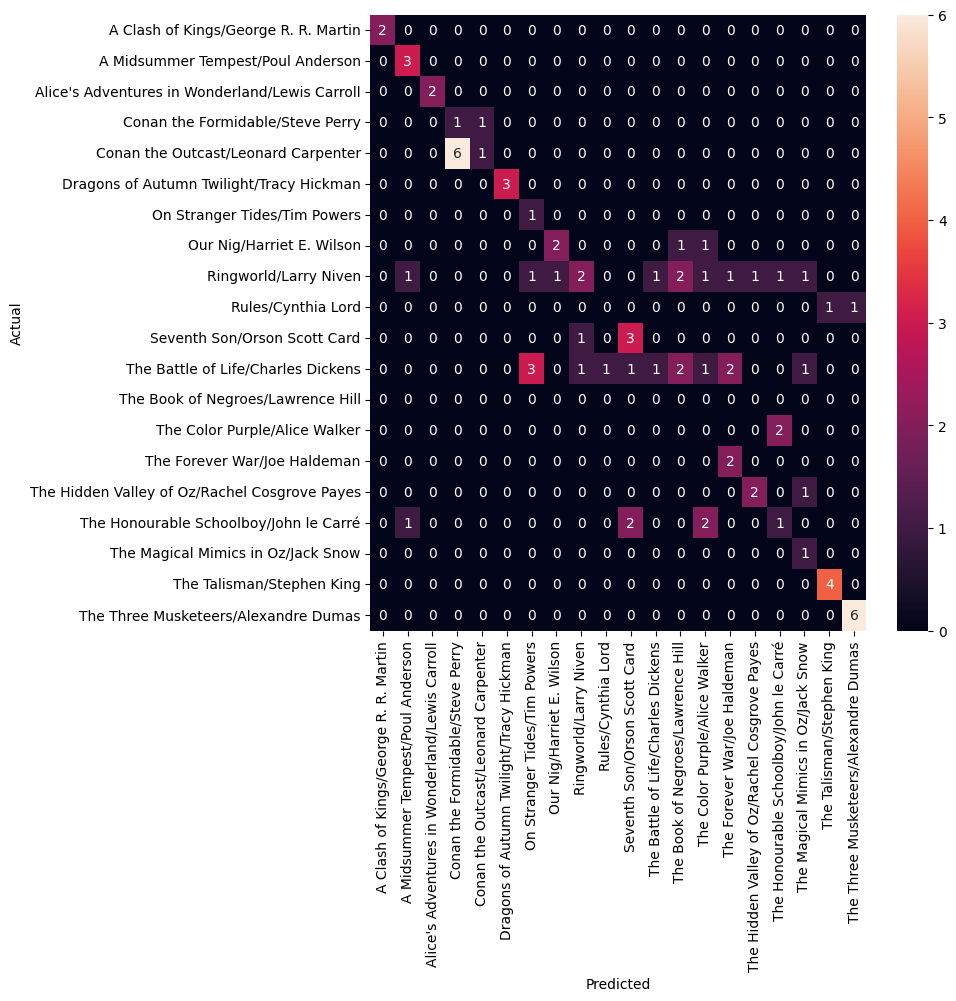

In [ ]:
pipeline_dt_tfid_ngram = Pipeline([
    ('tfid-ngram', TfidfVectorizer(ngram_range= (1, 2))),
    ('clf', DecisionTreeClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 2))
])
pipeline_dt_tfid_ngram.fit(X_train, y_train)
test_predictions_dt_tfid_ngram = pipeline_dt_tfid_ngram.predict(X_test)
train_predictions_dt_tfid_ngram = pipeline_dt_tfid_ngram.predict(X_train)

# Extract wrong predictions
print(" 2 ========> Decision Tree + TFID + NGRAM <========")
# df_dt_tfid_ngram = pd.DataFrame({"Prediction": label_encoder.inverse_transform(test_predictions_dt_tfid_ngram), "Actual": label_encoder.inverse_transform(y_test)})
# df_dt_tfid_ngram["Predicted Wrong"] = df_dt_tfid_ngram.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
# rslt_df_dt_tfid_ngram = df_dt_tfid_ngram[df_dt_tfid_ngram["Predicted Wrong"] == False]
# print(rslt_df_dt_tfid_ngram)
print()
report = classification_report(label_encoder.inverse_transform(test_predictions_dt_tfid_ngram), label_encoder.inverse_transform(y_test))
print(report)
accuracy = accuracy_score(y_test, test_predictions_dt_tfid_ngram)
print("Accuracy : ", accuracy)
conf_mat = confusion_matrix(test_predictions_dt_tfid_ngram, y_test)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")

### **KNN - BoW**

========> KNN + BOW <========

                                                precision    recall  f1-score   support

          A Clash of Kings/George R. R. Martin       1.00      1.00      1.00         2
             A Midsummer Tempest/Poul Anderson       1.00      1.00      1.00         5
Alice's Adventures in Wonderland/Lewis Carroll       1.00      1.00      1.00         2
              Conan the Formidable/Steve Perry       0.00      0.00      0.00         1
           Conan the Outcast/Leonard Carpenter       0.50      0.12      0.20         8
      Dragons of Autumn Twilight/Tracy Hickman       1.00      1.00      1.00         3
                  On Stranger Tides/Tim Powers       1.00      1.00      1.00         5
                     Our Nig/Harriet E. Wilson       1.00      0.38      0.55         8
                         Ringworld/Larry Niven       1.00      0.80      0.89         5
                            Rules/Cynthia Lord       1.00      1.00      1.00         1


Text(0.5, 58.2222222222222, 'Predicted')

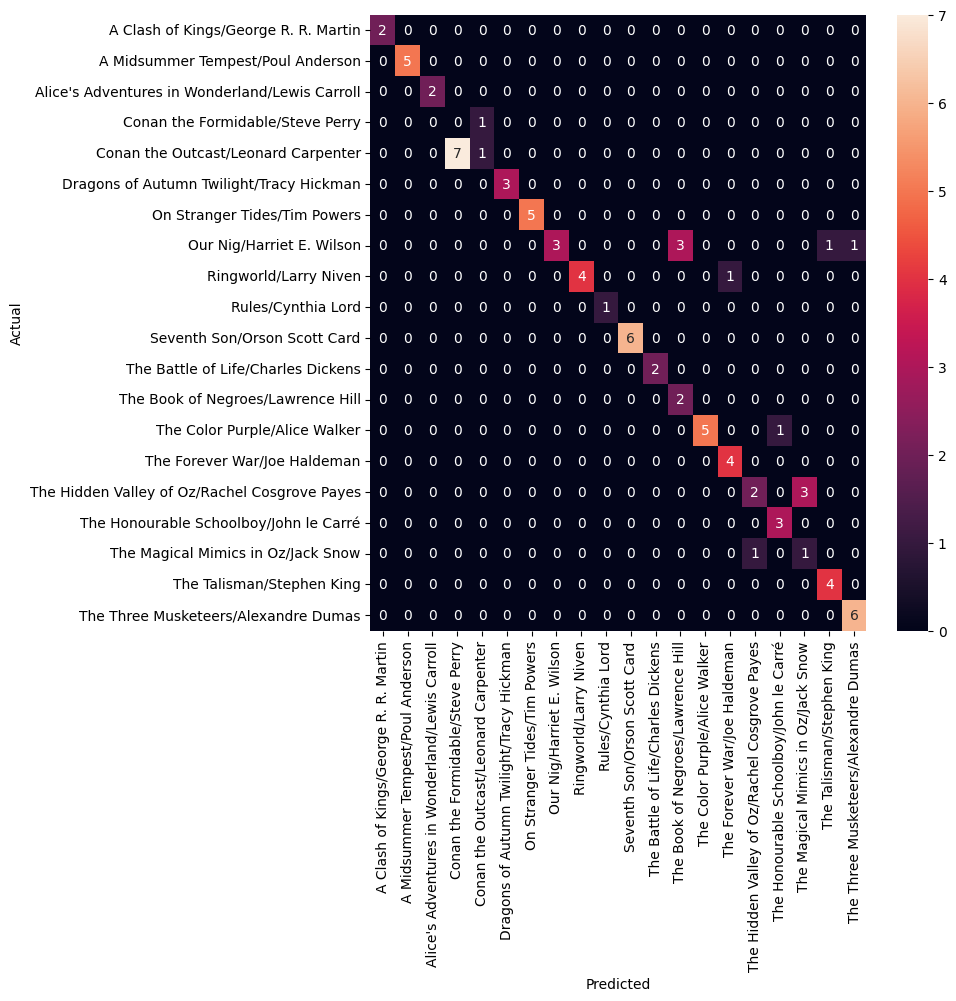

In [ ]:
## KNN
pipeline_knn_bow = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])
pipeline_knn_bow.fit(X_train, y_train)
test_predictions_knn_bow = pipeline_knn_bow.predict(X_test)
train_predictions_knn_bow = pipeline_knn_bow.predict(X_train)
# Extract wrong predictions
print("========> KNN + BOW <========")
# df_knn_bow = pd.DataFrame({"Prediction": label_encoder.inverse_transform(test_predictions_knn_bow), "Actual": label_encoder.inverse_transform(y_test)})
# df_knn_bow["Predicted Wrong"] = df_knn_bow.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
# rslt_df_knn_bow = df_knn_bow[df_knn_bow["Predicted Wrong"] == False]
# print(rslt_df_knn_bow)
print()
report = classification_report(label_encoder.inverse_transform(test_predictions_knn_bow), label_encoder.inverse_transform(y_test))
print(report)
accuracy = accuracy_score(y_test, test_predictions_knn_bow)
print("Accuracy : ", accuracy)
conf_mat = confusion_matrix(test_predictions_knn_bow, y_test)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")

### **KNN - TFIDF**

========> KNN + TFID <========

                                                precision    recall  f1-score   support

          A Clash of Kings/George R. R. Martin       1.00      0.67      0.80         3
             A Midsummer Tempest/Poul Anderson       1.00      1.00      1.00         5
Alice's Adventures in Wonderland/Lewis Carroll       1.00      1.00      1.00         2
              Conan the Formidable/Steve Perry       0.29      0.67      0.40         3
           Conan the Outcast/Leonard Carpenter       0.50      0.17      0.25         6
      Dragons of Autumn Twilight/Tracy Hickman       1.00      1.00      1.00         3
                  On Stranger Tides/Tim Powers       1.00      1.00      1.00         5
                     Our Nig/Harriet E. Wilson       1.00      0.50      0.67         6
                         Ringworld/Larry Niven       0.75      1.00      0.86         3
                            Rules/Cynthia Lord       1.00      1.00      1.00         1

Text(0.5, 58.2222222222222, 'Predicted')

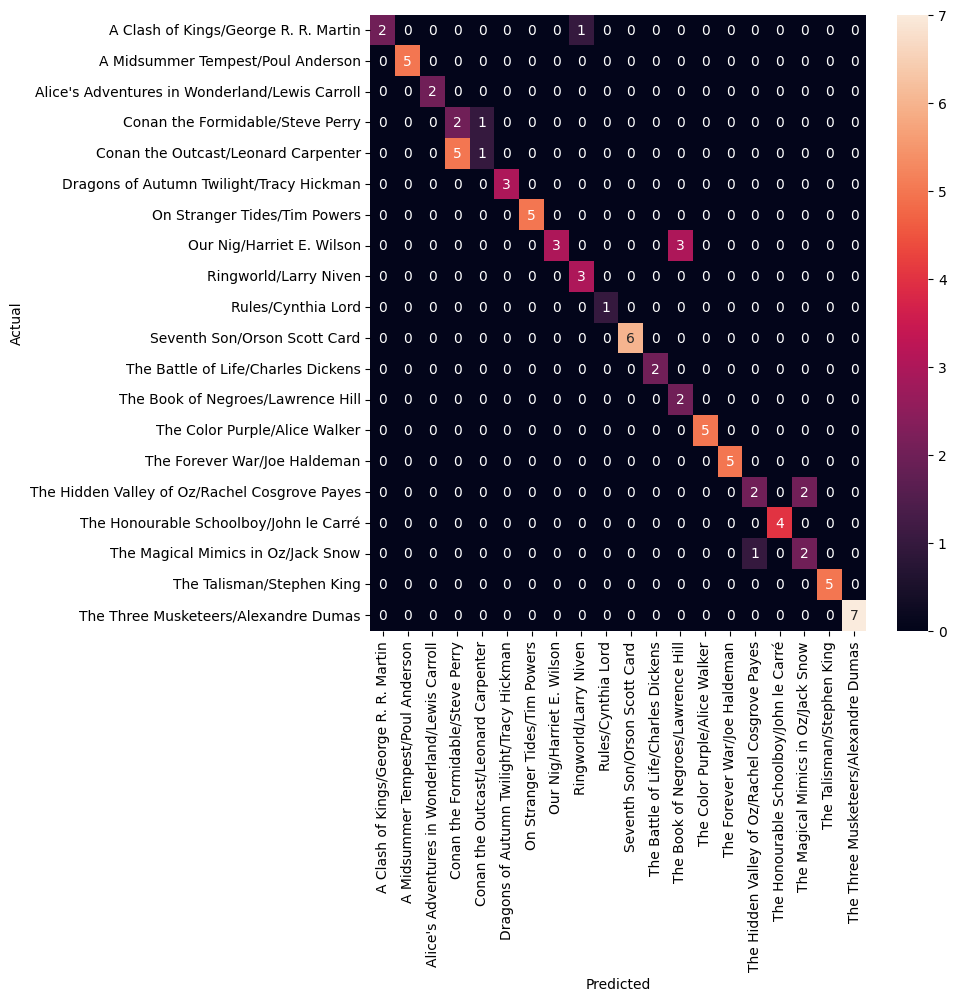

In [ ]:
pipeline_knn_tfid = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])
pipeline_knn_tfid.fit(X_train, y_train)
test_predictions_knn_tfid = pipeline_knn_tfid.predict(X_test)
train_predictions_knn_tfid = pipeline_knn_tfid.predict(X_train)

# Extract wrong predictions
print("========> KNN + TFID <========")
# df_knn_tfid = pd.DataFrame({"Prediction": label_encoder.inverse_transform(test_predictions_knn_tfid), "Actual": label_encoder.inverse_transform(y_test)})
# df_knn_tfid["Predicted Wrong"] = df_knn_tfid.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
# rslt_df_knn_tfid = df_knn_tfid[df_knn_tfid["Predicted Wrong"] == False]
# print(rslt_df_knn_tfid)
print()
report = classification_report(label_encoder.inverse_transform(test_predictions_knn_tfid), label_encoder.inverse_transform(y_test))
print(report)
accuracy = accuracy_score(y_test, test_predictions_knn_tfid)
print("Accuracy : ", accuracy)
conf_mat = confusion_matrix(test_predictions_knn_tfid, y_test)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")


### **KNN - NGram**

========> KNN + TFID + NGRAM <========
                                       Prediction  \
0                       Our Nig/Harriet E. Wilson   
6   The Hidden Valley of Oz/Rachel Cosgrove Payes   
15             The Magical Mimics in Oz/Jack Snow   
27                      Our Nig/Harriet E. Wilson   
33  The Hidden Valley of Oz/Rachel Cosgrove Payes   
36            Conan the Outcast/Leonard Carpenter   
48            Conan the Outcast/Leonard Carpenter   
51               Conan the Formidable/Steve Perry   
58            Conan the Outcast/Leonard Carpenter   
59                          Ringworld/Larry Niven   
65                      Our Nig/Harriet E. Wilson   
68                      Our Nig/Harriet E. Wilson   
73            Conan the Outcast/Leonard Carpenter   
76            Conan the Outcast/Leonard Carpenter   

                                           Actual  Predicted Wrong  
0               The Book of Negroes/Lawrence Hill            False  
6              The Magical 

Text(0.5, 58.2222222222222, 'Predicted')

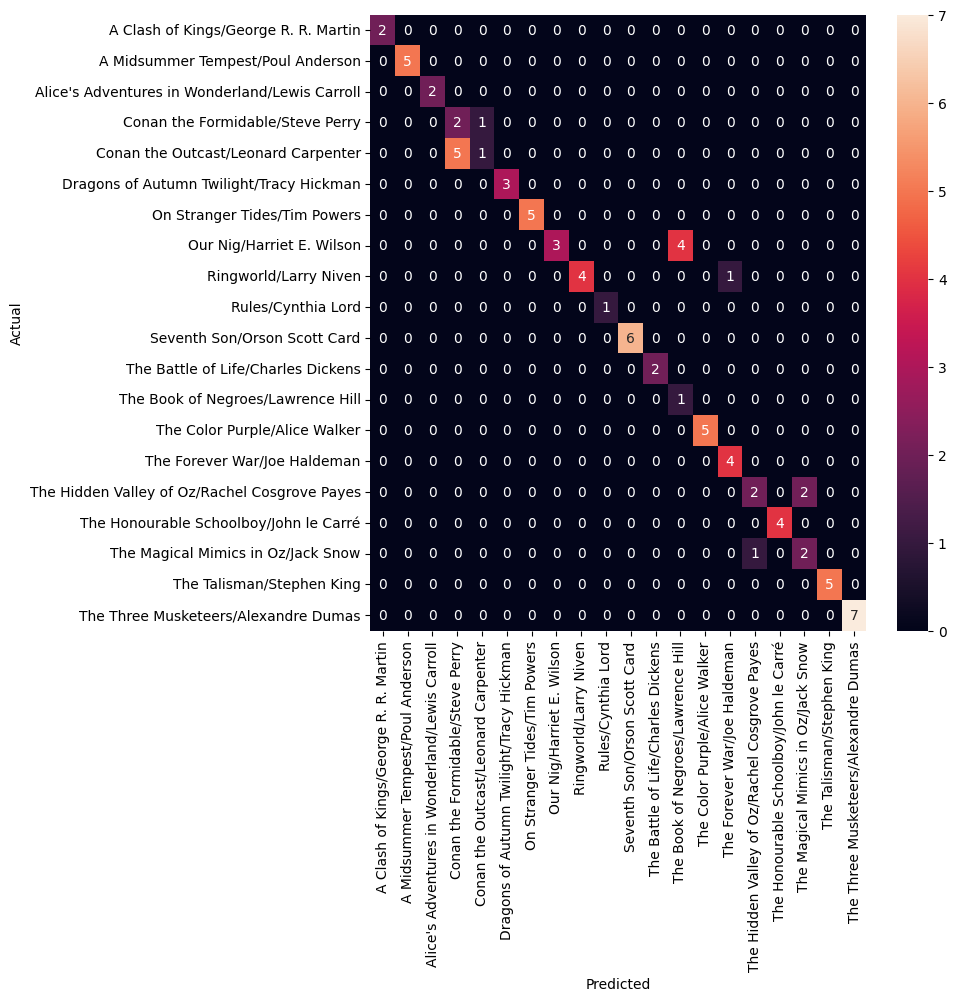

In [ ]:
pipeline_knn_tfid_ngram = Pipeline([
('tfid-ngram', TfidfVectorizer(ngram_range= (1, 2))),
    ('clf', KNeighborsClassifier(n_neighbors=6))
])
pipeline_knn_tfid_ngram.fit(X_train, y_train)
test_predictions_knn_tfid_ngram = pipeline_knn_tfid_ngram.predict(X_test)
train_predictions_knn_tfid_ngram = pipeline_knn_tfid_ngram.predict(X_train)

# Extract wrong predictions
print("========> KNN + TFID + NGRAM <========")
df_knn_tfid_ngram = pd.DataFrame({"Prediction": label_encoder.inverse_transform(test_predictions_knn_tfid_ngram), "Actual": label_encoder.inverse_transform(y_test)})
df_knn_tfid_ngram["Predicted Wrong"] = df_knn_tfid_ngram.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
rslt_df_knn_tfid_ngram = df_knn_tfid_ngram[df_knn_tfid_ngram["Predicted Wrong"] == False]
print(rslt_df_knn_tfid_ngram)
print()
report = classification_report(label_encoder.inverse_transform(test_predictions_knn_tfid_ngram), label_encoder.inverse_transform(y_test))
print(report)
accuracy = accuracy_score(y_test, test_predictions_knn_tfid_ngram)
print("Accuracy : ", accuracy)
conf_mat = confusion_matrix(test_predictions_knn_tfid_ngram, y_test)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")

### **Cross Validation**

In [ ]:
cross_validation_acc = {}

n_splits = 10
test_size = 0.1
random_state = 0

# SVM + BoW
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', SVC(C=1, kernel='linear', gamma=1))
])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
cross_validation_acc["SVM + BoW"] = scores.mean()

# SVM + TFID
pipeline = Pipeline([
    ('bow', TfidfVectorizer()),
    ('clf', SVC(C=1, kernel='linear', gamma=1))
])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
cross_validation_acc["SVM + TFIDF"] = scores.mean()

# SVM + TFID_ngram
pipeline = Pipeline([
    ('tfid_ngram', TfidfVectorizer(ngram_range= (1, 2))),
    ('clf', SVC(C=1, kernel='linear', gamma=1))
])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
cross_validation_acc["SVM + TFIDF_ngram"] = scores.mean()

# Decision Tree + BoW

pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10))
])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
cross_validation_acc["DT + BoW"] = scores.mean()

# Decision Tree + TFID

pipeline = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 2))
])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
cross_validation_acc["DT + TFIDF"] = scores.mean()

# Decision Tree + TFID_ngram

pipeline = Pipeline([
    ('tfid-ngram', TfidfVectorizer(ngram_range= (1, 2))),
    ('clf', DecisionTreeClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 2))
])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
cross_validation_acc["DT + TFIDF_ngram"] = scores.mean()

# KNN + BoW
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('clf', KNeighborsClassifier(n_neighbors=20))
])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
cross_validation_acc["KNN + BoW"] = scores.mean()

# KNN + tfid
pipeline = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('clf', KNeighborsClassifier(n_neighbors=7))
])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
cross_validation_acc["KNN + TFID"] = scores.mean()

# KNN + tfid_ngram
pipeline = Pipeline([
('tfid-ngram', TfidfVectorizer(ngram_range= (1, 2))),
    ('clf', KNeighborsClassifier(n_neighbors=7))
])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
cross_validation_acc["KNN + TFIDF_ngram"] = scores.mean()

# # XGBoost + BoW
# pipeline = Pipeline([
#     ('bow', CountVectorizer()),
#     ('clf', XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=300))
# ])
# cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
# scores = cross_val_score(pipeline, dataframe_clf['link'], y, cv=cv)
# cross_validation_acc["XGB + BoW"] = scores.mean()

# # XGBoost + TFID
# pipeline = Pipeline([
#     ('bow', TfidfVectorizer()),
#     ('clf', XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=200))
# ])
# cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
# scores = cross_val_score(pipeline, book1['Text'], y, cv=cv)
# cross_validation_acc["XGB + TFID"] = scores.mean()

# # XGBoost + TFID_ngram
# pipeline = Pipeline([
#     ('bow', TfidfVectorizer(ngram_range= (1, 2))),
#     ('clf', XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=200))
# ])
# cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
# scores = cross_val_score(pipeline, book1['Text'], y, cv=cv)
# cross_validation_acc["XGB + TFID_ngram"] = scores.mean()

cross_validation_result = pd.DataFrame(cross_validation_acc.items(),
                                       columns=["Classifier + Feature Engineering", "Average Accuracy"])
cross_validation_result

Classifier + Feature Engineering  Average Accuracy
0                        SVM + BoW            0.8250
1                      SVM + TFIDF            0.8250
2                SVM + TFIDF_ngram            0.8100
3                         DT + BoW            0.4725
4                       DT + TFIDF            0.5450
5                 DT + TFIDF_ngram            0.5250
6                        KNN + BoW            0.7425
7                       KNN + TFID            0.8550
8                KNN + TFIDF_ngram            0.8300

# **Artificial Neural Network**

In [ ]:
index_book=pd.Series(data.TitAut.values,index=data.index).to_dict()
book_index=pd.Series(data.index.values,index=data.TitAut).to_dict()

In [ ]:
unique_links = list(Counter(unique_links))

In [ ]:
len(unique_links)

74341

In [ ]:
link_index = {}
index_link = {}
for i, link in enumerate(unique_links):
  link_index[link] = i
  index_link[i] = link

In [ ]:
# read dataset
dataset = pd.read_csv("dataset.csv")
dataset.head()

### **Data Preprocessing**

Converting the book name, and link to numbers based on book_index and link_index

In [ ]:
dataset_conv = []
for row in dataset.itertuples():
    dataset_conv.append([book_index[row.BookAuthor], link_index[row.Link], row.Output])

In [ ]:
dataset_conv = pd.DataFrame(dataset_conv, columns = ["BookAuthor", "Link", "Output"])

In [ ]:
dataset_conv

BookAuthor   Link  Output
0              7388  20993       0
1              6154  31612       0
2              1876  13229       0
3              1823   1018       0
4              2263  31517       1
...             ...    ...     ...
1488633        2817   5988       0
1488634       10336  58080       1
1488635        1142   6589       0
1488636       10356  34695       0
1488637        1031  52410       0

[1488638 rows x 3 columns]

### **Creating the ANN Model**

In [ ]:
def create_model(batch_size):

    books = tf.keras.Input(name = 'books', shape = (1,))
    links = tf.keras.Input(name = 'Links', shape = (1,))

    book_embedding = tf.keras.layers.Embedding(name = 'book_embedding', input_dim = len(book_index), output_dim = 50)(books)
    link_embedding = tf.keras.layers.Embedding(name = 'link_embedding', input_dim = len(link_index), output_dim = 50)(links)

    Dot = tf.keras.layers.Dot(name = 'dot', axes = 2, normalize = True)([book_embedding, link_embedding])

    reshape = tf.keras.layers.Reshape(name = 'reshape', target_shape = [1])(Dot)

    output_layer = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(reshape)

    model = tf.keras.Model(inputs = [books, links], outputs = output_layer)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model


In [ ]:
model = create_model(50)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 books (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Links (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 book_embedding (Embedding)     (None, 1, 50)        606750      ['books[0][0]']                  
                                                                                                  
 link_embedding (Embedding)     (None, 1, 50)        3717100     ['Links[0][0]']                  
                                                                                            

In [ ]:
X1 = dataset_conv.iloc[:, 0].values
X2 = dataset_conv.iloc[:, 1].values
Y = dataset_conv.iloc[:, -1].values

**Model Training**

DO NOT RUN. It will take time. Instead load the model.

In [ ]:
result = model.fit(x=[X1, X2], y=Y, batch_size = 1024, epochs = 10, shuffle = True, verbose = 1)

Epoch 1/10
1457/1457 [==============================] - 95s 64ms/step - loss: 0.5963 - accuracy: 0.6904
Epoch 2/10
1457/1457 [==============================] - 95s 65ms/step - loss: 0.3177 - accuracy: 0.9230
Epoch 3/10
1457/1457 [==============================] - 97s 67ms/step - loss: 0.1960 - accuracy: 0.9671
Epoch 4/10
1457/1457 [==============================] - 98s 67ms/step - loss: 0.1336 - accuracy: 0.9838
Epoch 5/10
1457/1457 [==============================] - 96s 66ms/step - loss: 0.0942 - accuracy: 0.9913
Epoch 6/10
1457/1457 [==============================] - 96s 66ms/step - loss: 0.0673 - accuracy: 0.9950
Epoch 7/10
1457/1457 [==============================] - 97s 67ms/step - loss: 0.0484 - accuracy: 0.9970
Epoch 8/10
1457/1457 [==============================] - 97s 66ms/step - loss: 0.0349 - accuracy: 0.9982
Epoch 9/10
1457/1457 [==============================] - 96s 66ms/step - loss: 0.0251 - accuracy: 0.9990
Epoch 10/10
1457/1457 [==============================] - 93s 64m

In [ ]:
# model.save('Model_ann.h5')

### **Find Similar Books**

In [ ]:
model = load_model("Model_ann.h5")

In [ ]:
book_layer = model.get_layer('book_embedding')

In [ ]:
book_embeddings = book_layer.get_weights()[0]

In [ ]:
book_embeddings

array([[-0.1068086 , -0.03717268, -0.07663607, ...,  0.22562027,
        -0.03081166, -0.19784717],
       [-0.23474367, -0.1732931 ,  0.09861108, ...,  0.2445925 ,
         0.0219491 ,  0.0389595 ],
       [ 0.0087156 ,  0.10135525,  0.15204813, ...,  0.24175331,
        -0.2076332 , -0.02680548],
       ...,
       [-0.11584511,  0.00082433,  0.03243738, ..., -0.08202355,
        -0.11517467, -0.01191509],
       [-0.14042199, -0.1283048 ,  0.06978748, ..., -0.00551504,
         0.05459137,  0.08650279],
       [-0.03709226, -0.0164709 , -0.03413469, ...,  0.01862065,
         0.03426893,  0.10751582]], dtype=float32)

In [ ]:
norm = np.linalg.norm(book_embeddings, axis = 1).reshape(12135, 1)
norm

array([[0.8448518 ],
       [0.8172707 ],
       [0.8018086 ],
       ...,
       [0.71817017],
       [0.6372224 ],
       [0.79842216]], dtype=float32)

In [ ]:
norm_book_embeddings = book_embeddings / norm
norm_book_embeddings

array([[-0.12642288, -0.04399905, -0.09070949, ...,  0.26705307,
        -0.0364699 , -0.23417974],
       [-0.2872288 , -0.2120388 ,  0.12065902, ...,  0.29927966,
         0.02685658,  0.04767025],
       [ 0.01086992,  0.12640828,  0.18963145, ...,  0.30151   ,
        -0.25895607, -0.03343127],
       ...,
       [-0.16130593,  0.00114783,  0.0451667 , ..., -0.11421186,
        -0.16037239, -0.0165909 ],
       [-0.22036573, -0.2013501 ,  0.10951824, ..., -0.00865482,
         0.08567082,  0.13574976],
       [-0.04645696, -0.02062931, -0.04275268, ...,  0.02332181,
         0.04292082,  0.13466036]], dtype=float32)

In [ ]:
np.sum(np.square(norm_book_embeddings[0]))

0.9999999

In [ ]:
book_embeddings = norm_book_embeddings.tolist()

In [ ]:
book_embeddings = np.array(book_embeddings, dtype = float)

In [ ]:
def recommendation(book, book_embeddings):

    dist = np.dot(book_embeddings, book_embeddings[book_index[book]])
    sort_dist = np.argsort(dist)

    recommendation = []
    for i in np.flipud(sort_dist[-10:]):
        recommendation.append([index_book[i], dist[i]])
    return recommendation


In [ ]:
def plot_result(data):
  title = data[0][0]
  data = data[1:]

  x_values = [d[1] for d in data]
  y_labels = [d[0] for d in data]

  fig, ax = plt.subplots(figsize=(12,6))

  ax.barh(y_labels, x_values, color='g')

  ax.set_title(title)
  ax.set_xlabel("Similarity")
  ax.set_ylabel("Recommended Books")

  # Set the x-axis scale from 0.85 to 1.0
  ax.set_xlim(x_values[-1]-0.05, x_values[0]+0.05)

  # Add score values next to the bars
  for i, v in enumerate(x_values):
      ax.text(v + 0.01, i, str(round(v, 2)), color='blue')


  plt.tight_layout()

  plt.show()


### **Output of the recommendations**

In [ ]:
recommendation('Invincible/Troy Denning', book_embeddings)

[['Invincible/Troy Denning', 0.9999998866291326],
 ['The Deadly Hunter/Judy Blundell', 0.9096104240684966],
 ['The Dangerous Games/Judy Blundell', 0.9056733876941208],
 ['Force Heretic: Reunion/Sean Williams', 0.9014633501094542],
 ['The Unifying Force/James Luceno', 0.9000341579525467],
 ['Recovery/Troy Denning', 0.8998790932850661],
 ['The New Rebellion/Kristine Kathryn Rusch', 0.8965315633502877],
 ['The Final Showdown/Judy Blundell', 0.8947410304563077],
 ['Exile/Aaron Allston', 0.8943220787893129],
 ['The Final Prophecy/Gregory Keyes', 0.8899535477455852]]

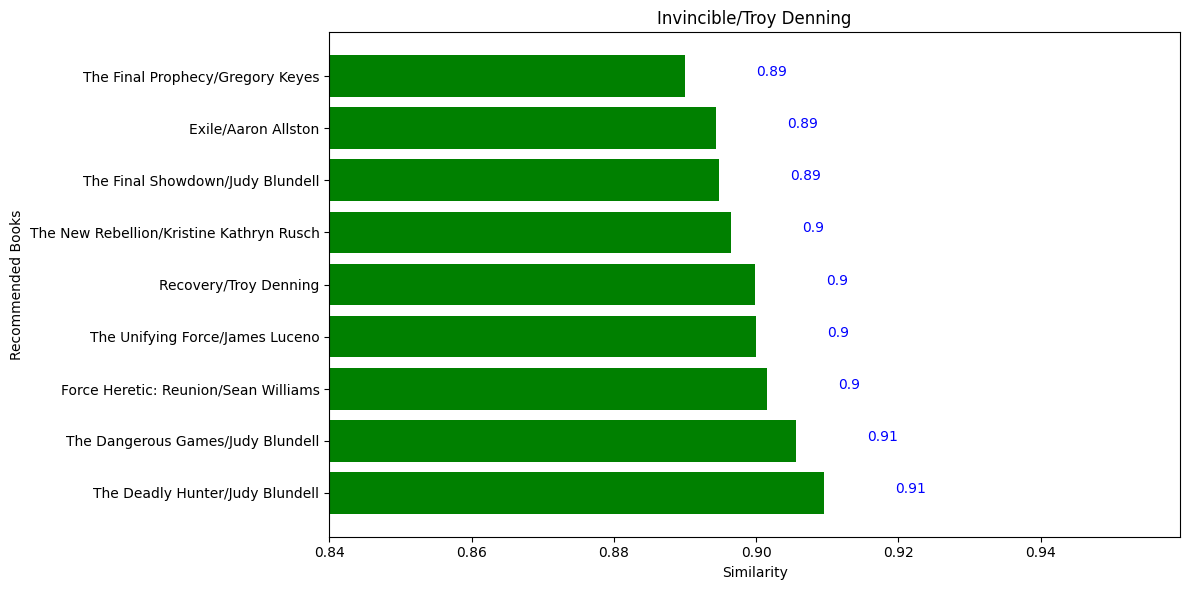

In [ ]:
plot_result(recommendation('Invincible/Troy Denning', book_embeddings))


In [ ]:
recommendation('Oceanic/Greg Egan', book_embeddings)

[['Oceanic/Greg Egan', 1.000000010447827],
 ['Enemy Mine/David Gerrold', 0.7945629442127072],
 ['The Cookie Monster/Vernor Vinge', 0.758199476508084],
 ['Dragonflight/Anne McCaffrey', 0.7477602431189774],
 ['All Seated on the Ground/Connie Willis', 0.7377052756612619],
 ['Coraline/Neil Gaiman', 0.7251821398587197],
 ['My Name is Legion/Roger Zelazny', 0.7250211689480843],
 ['The Word for World is Forest/Ursula K. Le Guin', 0.7100471360882817],
 ['Beggars in Spain/Nancy Kress', 0.7043360300844996],
 ['Down in the Bottomlands/Harry Turtledove', 0.698811545213186],
 ['Metropolitan/Walter Jon Williams', 0.6898424582932221],
 ['Eye for Eye/Orson Scott Card', 0.6531784053386466],
 ['Thud!/Terry Pratchett', 0.6447683477012409],
 ['Wintersmith/Terry Pratchett', 0.639120524312533],
 ['The Dream Master/Roger Zelazny', 0.6272669142537082],
 ['Moving Pictures/Terry Pratchett', 0.6261329147699337],
 ['Going Postal/Terry Pratchett', 0.6223701059345319],
 ['Fablehaven: Rise of the Evening Star/Brando

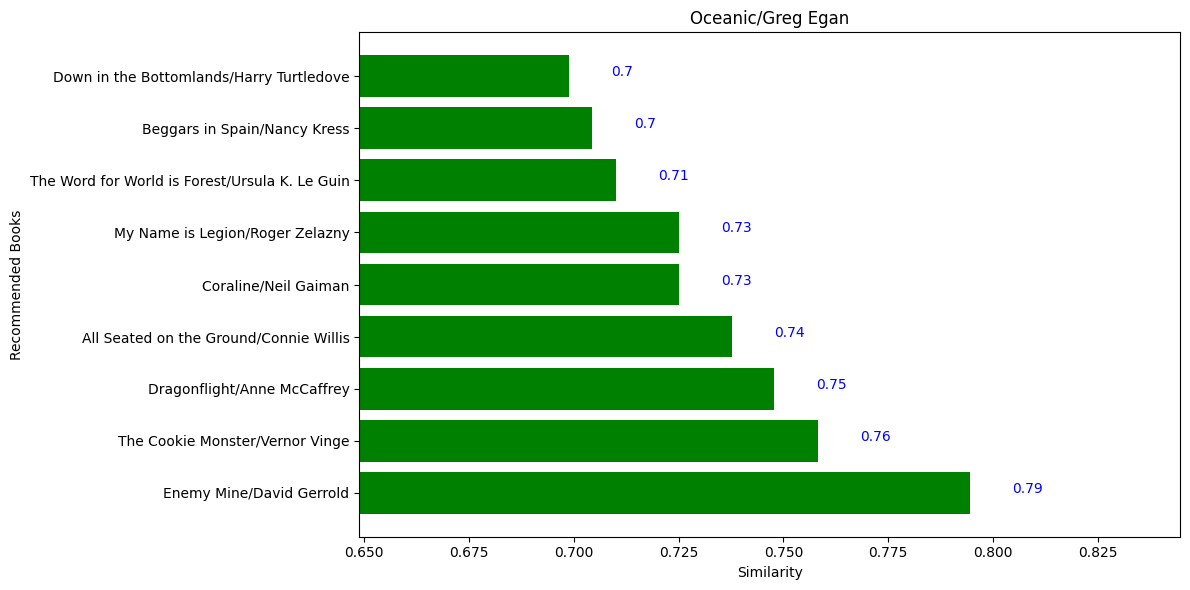

In [ ]:
plot_result(recommendation('Oceanic/Greg Egan', book_embeddings))

In [ ]:
recommendation('Harry Potter and the Half-Blood Prince/J. K. Rowling', book_embeddings)

[['Harry Potter and the Half-Blood Prince/J. K. Rowling', 1.0000000944668215],
 ['Harry Potter and the Deathly Hallows/J. K. Rowling', 0.8955179501425364],
 ['Harry Potter and the Order of the Phoenix/J. K. Rowling',
  0.8888135190219368],
 ['Quidditch Through the Ages/J. K. Rowling', 0.8737975126959776],
 ["Harry Potter and the Philosopher's Stone/J. K. Rowling",
  0.8530962654946536],
 ['Harry Potter and the Chamber of Secrets/J. K. Rowling', 0.8456086313679196],
 ['Fantastic Beasts and Where to Find Them/J. K. Rowling', 0.8329113620968172],
 ['Harry Potter and the Goblet of Fire/J. K. Rowling', 0.8087545696144176],
 ['Harry Potter and the Prisoner of Azkaban/J. K. Rowling',
  0.7856390829757935],
 ['The Casual Vacancy/J. K. Rowling', 0.7560361444980599],
 ['Tomorrow, When the the War Began/John Marsden', 0.6516535956174583],
 ['The Night Circus/Erin Morgenstern', 0.5990920100223165],
 ['The Black Tattoo/Sam Enthoven', 0.5981283688875607],
 ['Cloudy with a Chance of Meatballs/Judi Ba

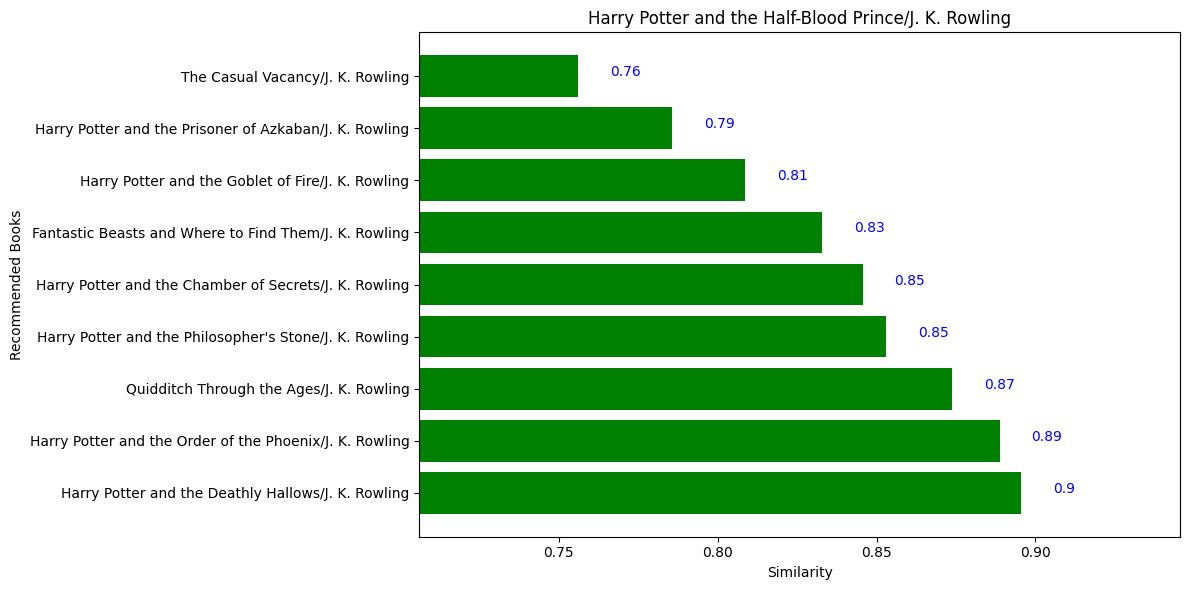

In [ ]:
plot_result(recommendation('Harry Potter and the Half-Blood Prince/J. K. Rowling', book_embeddings))

In [ ]:
recommendation('Conan the Formidable/Steve Perry', book_embeddings)

[['Conan the Formidable/Steve Perry', 0.9999999646558233],
 ['Conan of Aquilonia/Lin Carter', 0.8674537139383455],
 ['The Road of Kings/Karl Edward Wagner', 0.8672433184668997],
 ['Conan the Valiant/Roland J. Green', 0.8452691338284116],
 ['Conan the Mercenary/Andrew J. Offutt', 0.8452621683848913],
 ['Conan the Great/Leonard Carpenter', 0.8439000707013553],
 ['Conan and the Spider God/L. Sprague de Camp', 0.8433034237024057],
 ['Conan the Outcast/Leonard Carpenter', 0.8420025144159823],
 ['Conan: Scourge of the Bloody Coast/Leonard Carpenter', 0.8413259090557671],
 ['Conan the Swordsman/Björn Nyberg', 0.8401131538737152]]

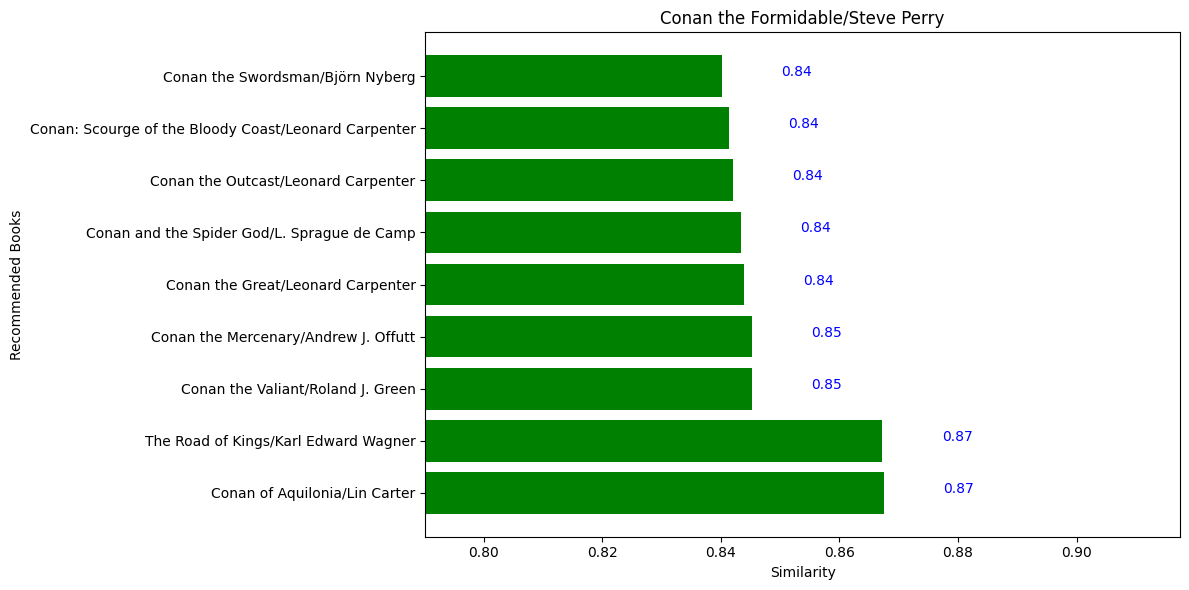

In [ ]:
plot_result(recommendation('Conan the Formidable/Steve Perry', book_embeddings))

In [ ]:
recommendation('The Book of Negroes/Lawrence Hill', book_embeddings)

[['The Book of Negroes/Lawrence Hill', 1.0000000814559917],
 ['Jubilee/Jack Dann', 0.8807129923707513],
 ['Our Nig/Harriet E. Wilson', 0.8605872115962203],
 ['The Life of Josiah Henson/Josiah Henson', 0.8579721890819307],
 ['Narrative of the Life of Frederick Douglass, an American Slave/Frederick Douglass',
  0.8526324718922147],
 ["The Bondwoman's Narrative/Hannah Crafts", 0.8507244196199353],
 ['Dred: A Tale of the Great Dismal Swamp/Harriet Beecher Stowe',
  0.842612666379159],
 ['Kindred/Octavia E. Butler', 0.8405270038239125],
 ['Roots: The Saga of an American Family/Alex Haley', 0.8358936556510151],
 ['Clotel/William Wells Brown', 0.8281166791182393]]

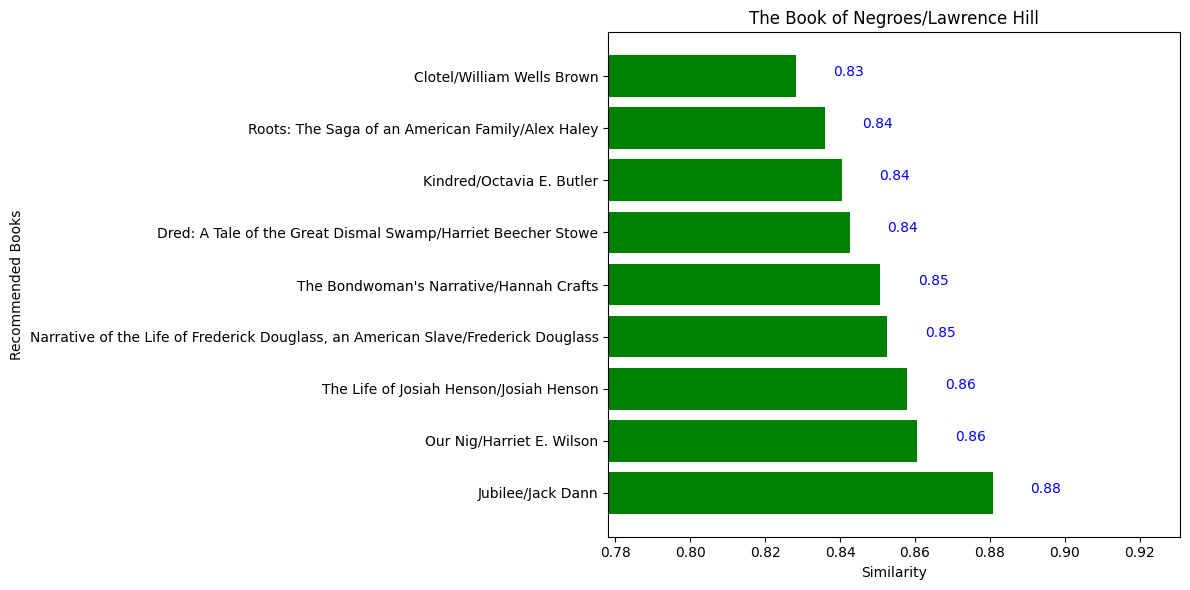

In [ ]:
plot_result(recommendation('The Book of Negroes/Lawrence Hill', book_embeddings))

In [ ]:
recommendation('The Magical Mimics in Oz/Jack Snow', book_embeddings)

[['The Magical Mimics in Oz/Jack Snow', 1.0000000189960838],
 ['Jack Pumpkinhead of Oz/Ruth Plumly Thompson', 0.9078286030853077],
 ['Mr. Tinker in Oz/James Howe', 0.9016957552503267],
 ['Kabumpo in Oz/Ruth Plumly Thompson', 0.9009563849338063],
 ['The Lost Princess of Oz/L. Frank Baum', 0.9000954307759502],
 ['Dorothy and the Wizard in Oz/L. Frank Baum', 0.8988252824693819],
 ['The Lost King of Oz/Ruth Plumly Thompson', 0.8938412289527448],
 ['The Shaggy Man of Oz/Jack Snow', 0.8904563833145076],
 ['Handy Mandy in Oz/Ruth Plumly Thompson', 0.8869371673679822],
 ['Rinkitink in Oz/L. Frank Baum', 0.8850208093452506],
 ['The Hidden Valley of Oz/Rachel Cosgrove Payes', 0.8771861639712393],
 ['Glinda of Oz/L. Frank Baum', 0.8750561410711609]]

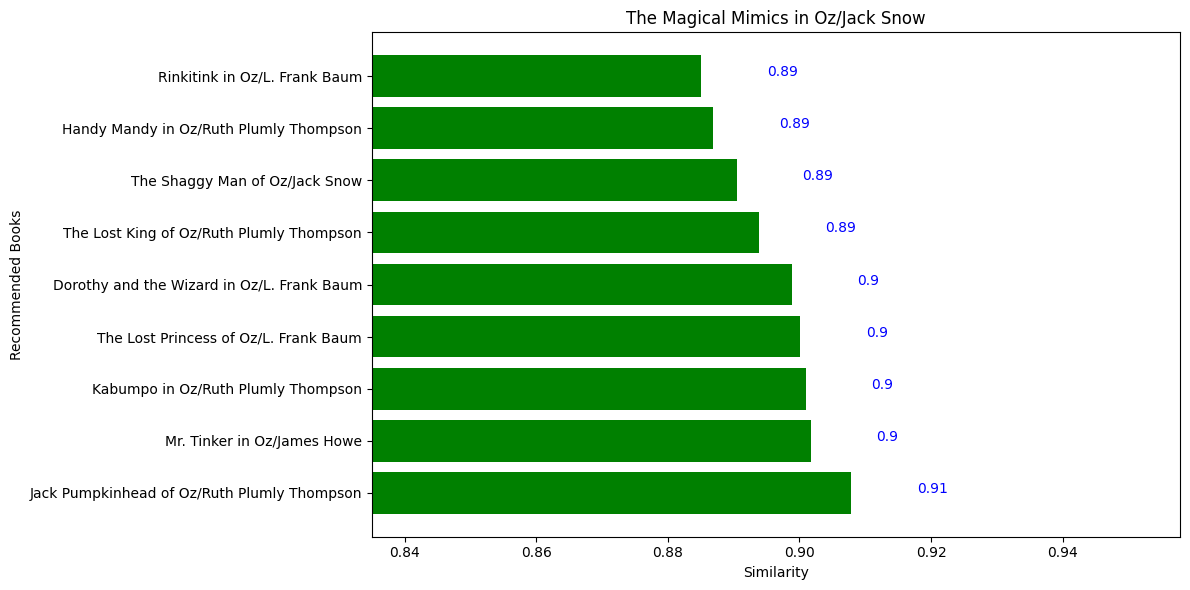

In [ ]:
plot_result(recommendation('The Magical Mimics in Oz/Jack Snow', book_embeddings))

In [ ]:
recommendation('The Forever War/Joe Haldeman', book_embeddings)

[['The Forever War/Joe Haldeman', 0.999999957734689],
 ['The Windup Girl/Paolo Bacigalupi', 0.8109490790745038],
 ['Gateway/Frederik Pohl', 0.7642337678224047],
 ['The Vor Game/Lois McMaster Bujold', 0.7582185971206405],
 ['Where Late the Sweet Birds Sang/Kate Wilhelm', 0.7574597352252559],
 ['The Snow Queen/Joan D. Vinge', 0.7573533551706884],
 ['Isle of the Dead/Roger Zelazny', 0.7505316813117247],
 ['The Falling Woman/Pat Murphy', 0.7484768753620028],
 ['Double Star/Robert A. Heinlein', 0.7383874068025329],
 ['Mirror Dance/Lois McMaster Bujold', 0.7359235905306989],
 ['Forever Free/Joe Haldeman', 0.7317722176265056],
 ['...And Call Me Conrad/Roger Zelazny', 0.7174455060564839],
 ['Time in Advance/William Tenn', 0.7131140922777348],
 ['The Dragon in the Sea/Frank Herbert', 0.7092763812517973],
 ['Farmer in the Sky/Robert A. Heinlein', 0.7061886890186312],
 ['Barrayar/Lois McMaster Bujold', 0.7038851062932231],
 ['Stranger in a Strange Land/Robert A. Heinlein', 0.7012058961474984],
 [

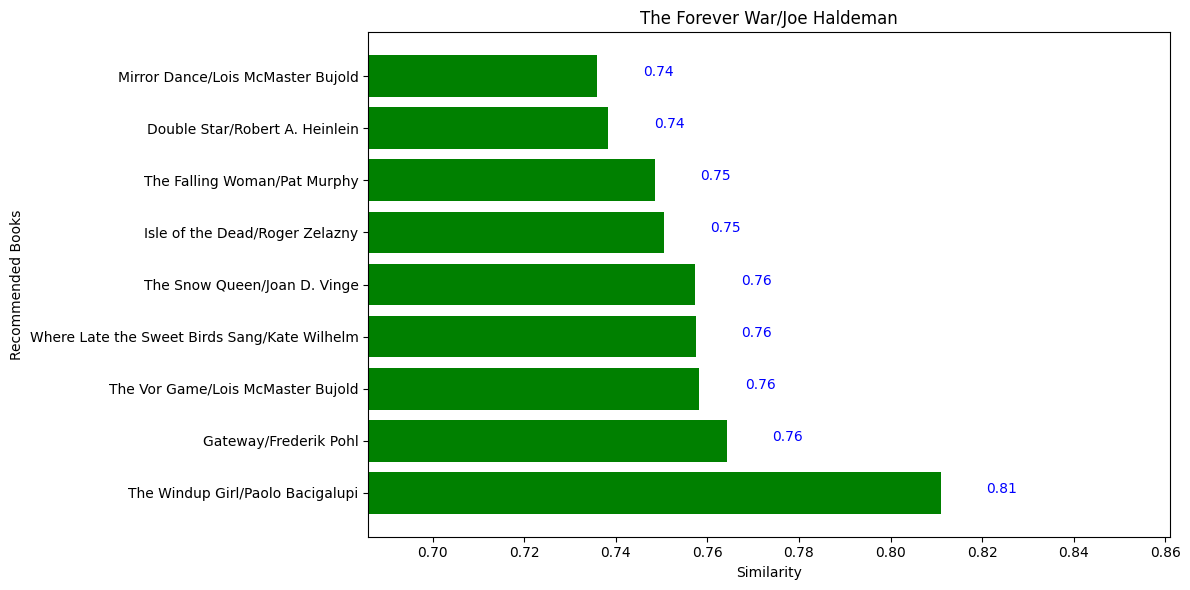

In [ ]:
plot_result(recommendation('The Forever War/Joe Haldeman', book_embeddings))

In [ ]:
count=0
common_link = " "
for link in temp_book_links['The Forever War/Joe Haldeman']:

  if link in temp_book_links['Ringworld/Larry Niven']:
    common_link+= link +" "
    count+=1

common_link = common_link.replace("novel", "")

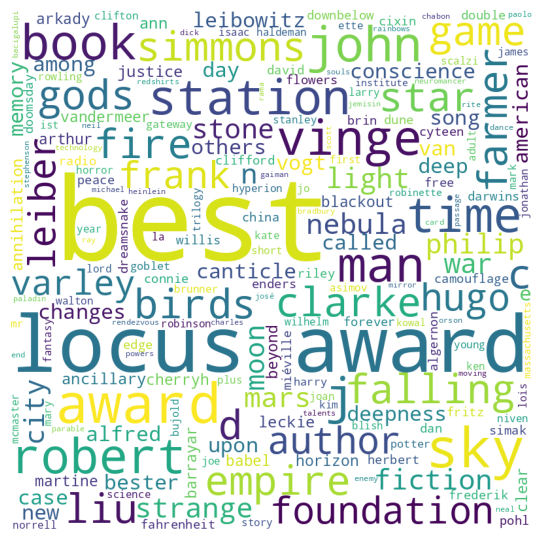

In [ ]:
# st = ""
# for i in dataframe_clf['link']:
#   st = st+ i + " "
# st = st.strip()

wordcloud = WordCloud(width=800, height=800,
                  background_color='white',
                  stopwords=None,
                  min_font_size=10).generate(common_link)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=10)
# plt.title(record[0]+' by '+record[1])

plt.show()
print()

# **Clustering**

In [ ]:
random.seed(25)
random_embedding = random.sample(list(book_embeddings), 2000)

In [ ]:
random_embedding[:2]

[array([ 0.09481424,  0.05321096, -0.12974685,  0.01824242, -0.05392431,
         0.12749763, -0.34367496, -0.20027009,  0.10650658,  0.18665421,
        -0.20630758,  0.2369117 ,  0.04547382,  0.14140363, -0.04716985,
         0.07388712, -0.20053138,  0.05083041, -0.01840555,  0.19309928,
         0.26313302,  0.20364241,  0.11750004, -0.20261832,  0.31366697,
         0.16490279,  0.08605748,  0.21071501, -0.04442111,  0.16512892,
         0.00855922,  0.07454325, -0.12587151, -0.08244745,  0.08195496,
         0.05008776,  0.02686763, -0.09706997,  0.1995904 ,  0.14497289,
        -0.03335115,  0.12687857, -0.14125285, -0.01376761,  0.04650502,
         0.08498443, -0.00679347, -0.02951333, -0.02466811, -0.09813205]),
 array([-0.06140692,  0.04453835,  0.0853656 , -0.01023025,  0.01178427,
         0.05256891,  0.03021499,  0.11345835,  0.03355008,  0.12952164,
         0.07321675,  0.16200535,  0.23984548,  0.12816894, -0.07333927,
         0.11482006,  0.28264961, -0.16684198,  0

1
2
3
4
5
6
7
8
9
10


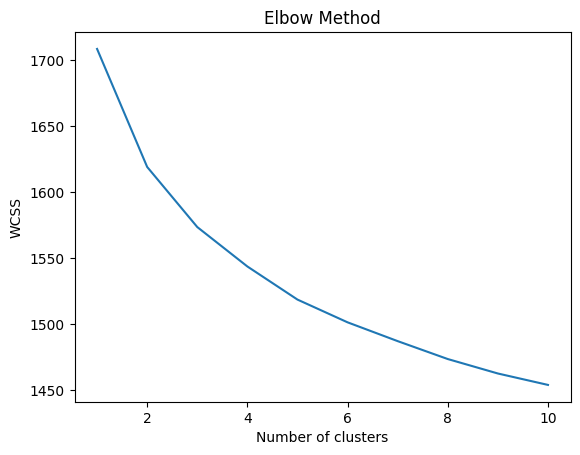

In [ ]:
# determine the optimum number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    print(i)
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(random_embedding)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# fit K-means with the optimum number of clusters (determined by the elbow method)

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(random_embedding)

# # add the cluster labels to the dataframe
# df['cluster'] = kmeans.labels_

# # print the cluster centers
# print(kmeans.cluster_centers_)


KMeans(n_clusters=5, n_init=10, random_state=0)

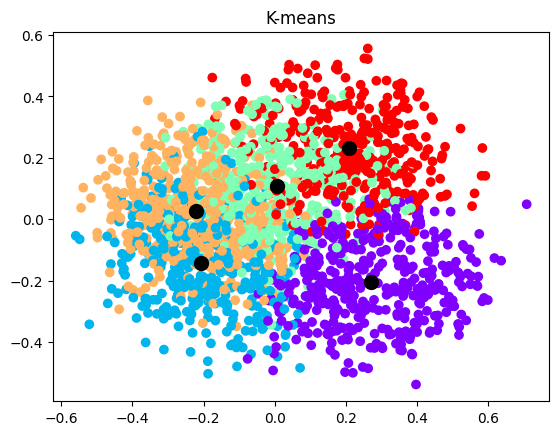

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
plt.figure()
colors = ['r', 'g', 'b', 'c', 'm']#, 'y', 'k', 'purple', 'orange', 'brown']
title = "K-means"
plt.title(label=title, loc="center")

datapoint = pca.fit_transform(random_embedding)
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=kmeans.labels_, cmap="rainbow")

centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], s=100, c="black")

# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA(n_components=2)
# plt.figure()

# colors = ['r', 'g', 'b', 'c', 'm']#, 'y', 'k', 'purple', 'orange', 'brown']
# title = "K-means"
# plt.title(label=title, loc="center")

# datapoint = pca.fit_transform(random_embedding)
# scatter = plt.scatter(datapoint[:, 0], datapoint[:, 1], c=kmeans.labels_, cmap="rainbow")

# centroids = kmeans.cluster_centers_
# centroidpoint = pca.transform(centroids)

# cluster_indices = list(set(kmeans.labels_))
# for i, index in enumerate(cluster_indices):
#     cluster_datapoint = datapoint[kmeans.labels_ == index]
#     color = colors[i % len(colors)]
#     plt.scatter(cluster_datapoint[:, 0], cluster_datapoint[:, 1], s=100, c=color, alpha=0.5)

# plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], s=100, c="black")

# plt.legend(*scatter.legend_elements())
# plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(random_embedding,  kmeans.labels_)

0.033680460990507186

In [ ]:
def recom(book, book_embeddings):

    dist = np.dot(book_embeddings, book)
    sort_dist = np.argsort(dist)

    recommendation = []
    for i in np.flipud(sort_dist[-20:]):
        recommendation.append([index_book[i], dist[i]])
    return recommendation


original_centroids = pca.inverse_transform(centroidpoint)
for val in original_centroids:
  print(recom(val, random_embedding)[0])

['Wonderful Life: The Burgess Shale and the Nature of History/Stephen Jay Gould', 0.2966624051112682]
['One Hundred Years of Solitude/Gabriel García Márquez', 0.35878129163206207]
['The Picture of Dorian Gray/Oscar Wilde', 0.3609980079117953]
['The Pit and the Pendulum/Nancy Kilpatrick', 0.3845420304617639]
['Only You Can Save Mankind/Terry Pratchett', 0.3889464223870244]


In [ ]:
# !pip install wikipedia

In [ ]:
# import wikipedia
# # Set language (optional)
# wikipedia.set_lang("en")
# # Search for a page
# page = wikipedia.page("Persuasion book")
# # Get the title of the page
# title = page.title
# # Get the content of the page
# content = page.content
# # Get the hyperlinks in the content
# hyperlinks = page.links
# # Print the title and hyperlinks
# print("Title:", title)
# len(hyperlinks)
